In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/NEUROCIRUGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=167.0, y1=102.2
Page 1, Q1, A: Yellow pixels: 1279
Page 1, Q1, A: Total non-white pixels: 1653
Page 1, Q1, A: Yellow percentage: 77.4%


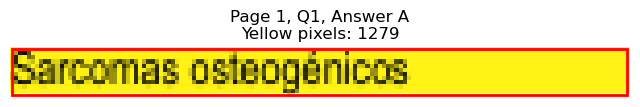

Page 1, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=173.2, y1=114.8
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 580
Page 1, Q1, B: Yellow percentage: 0.0%


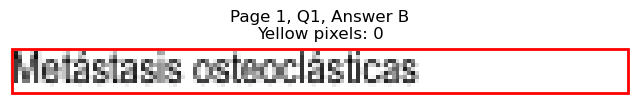

Page 1, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=408.7, y1=102.2
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 407
Page 1, Q1, C: Yellow percentage: 0.0%


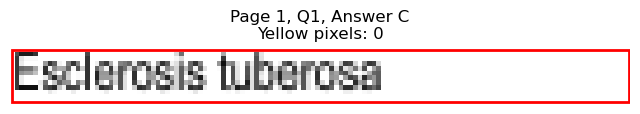

Page 1, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=417.7, y1=114.8
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 463
Page 1, Q1, D: Yellow percentage: 0.0%


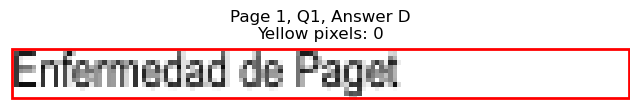


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=173.0, y1=165.3
Page 1, Q2, A: Yellow pixels: 156
Page 1, Q2, A: Total non-white pixels: 663
Page 1, Q2, A: Yellow percentage: 23.5%


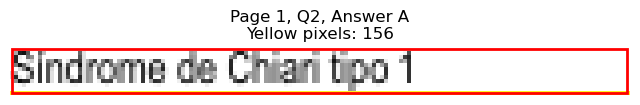

Page 1, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=196.7, y1=177.9
Page 1, Q2, B: Yellow pixels: 1636
Page 1, Q2, B: Total non-white pixels: 2148
Page 1, Q2, B: Yellow percentage: 76.2%


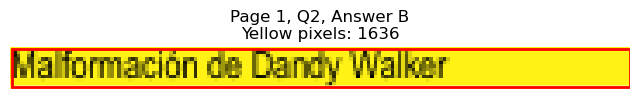

Page 1, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=423.7, y1=165.3
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 495
Page 1, Q2, C: Yellow percentage: 0.0%


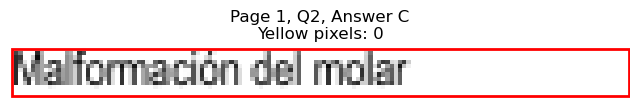

Page 1, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=432.2, y1=177.9
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 525
Page 1, Q2, D: Yellow percentage: 0.0%


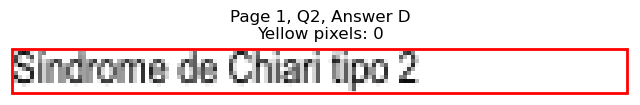


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=419.3, y1=241.0
Page 1, Q3, A: Yellow pixels: 3517
Page 1, Q3, A: Total non-white pixels: 4825
Page 1, Q3, A: Yellow percentage: 72.9%


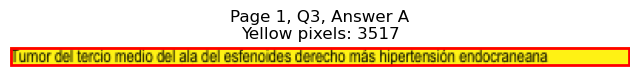

Page 1, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=294.5, y1=253.6
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 1113
Page 1, Q3, B: Yellow percentage: 0.0%


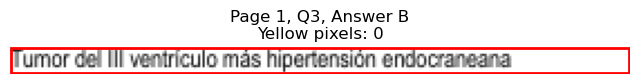

Page 1, Q3 - C: Detected box: x0=68.8, y0=255.2, x1=220.7, y1=266.2
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 718
Page 1, Q3, C: Yellow percentage: 0.0%


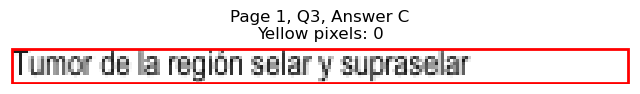

Page 1, Q3 - D: Detected box: x0=68.8, y0=267.8, x1=179.6, y1=278.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 571
Page 1, Q3, D: Yellow percentage: 0.0%


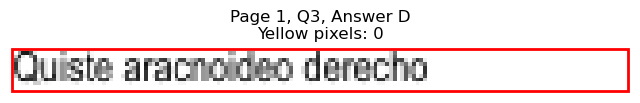


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=303.5, y1=329.4
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 1107
Page 1, Q4, A: Yellow percentage: 0.0%


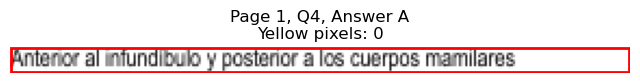

Page 1, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=277.4, y1=342.0
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 1015
Page 1, Q4, B: Yellow percentage: 0.0%


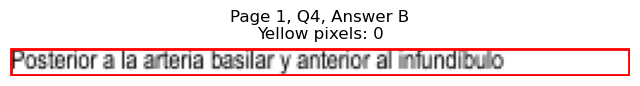

Page 1, Q4 - C: Detected box: x0=68.8, y0=343.6, x1=304.0, y1=354.7
Page 1, Q4, C: Yellow pixels: 286
Page 1, Q4, C: Total non-white pixels: 1415
Page 1, Q4, C: Yellow percentage: 20.2%


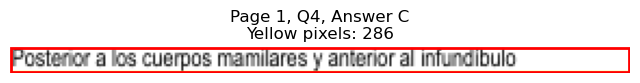

Page 1, Q4 - D: Detected box: x0=68.8, y0=356.2, x1=416.8, y1=367.3
Page 1, Q4, D: Yellow pixels: 3094
Page 1, Q4, D: Total non-white pixels: 4788
Page 1, Q4, D: Yellow percentage: 64.6%


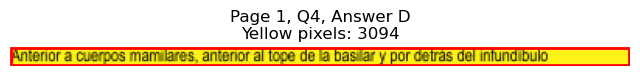


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=121.4, y1=430.4
Page 1, Q5, A: Yellow pixels: 904
Page 1, Q5, A: Total non-white pixels: 1248
Page 1, Q5, A: Yellow percentage: 72.4%


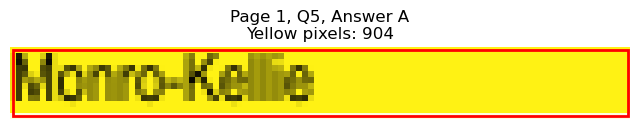

Page 1, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=125.9, y1=443.0
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 297
Page 1, Q5, B: Yellow percentage: 0.0%


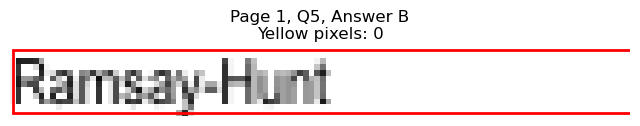

Page 1, Q5 - C: Detected box: x0=327.5, y0=419.4, x1=386.6, y1=430.4
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 289
Page 1, Q5, C: Yellow percentage: 0.0%


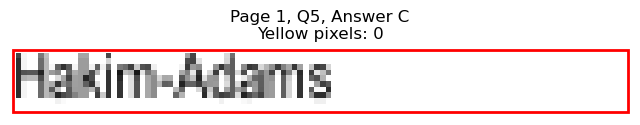

Page 1, Q5 - D: Detected box: x0=327.5, y0=432.0, x1=387.1, y1=443.0
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 318
Page 1, Q5, D: Yellow percentage: 0.0%


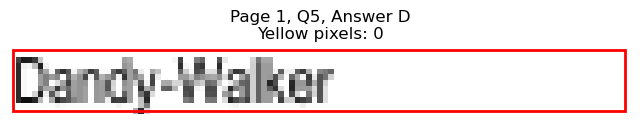


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=142.0, y1=480.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 408
Page 1, Q6, A: Yellow percentage: 0.0%


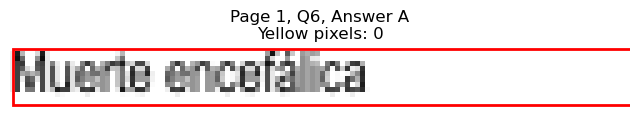

Page 1, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=153.0, y1=493.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 424
Page 1, Q6, B: Yellow percentage: 0.0%


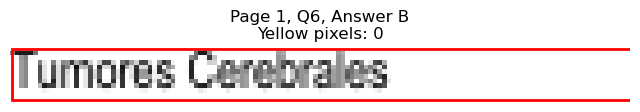

Page 1, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=400.2, y1=480.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 490
Page 1, Q6, C: Yellow percentage: 0.0%


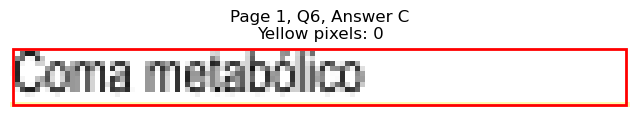

Page 1, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=453.4, y1=493.5
Page 1, Q6, D: Yellow pixels: 1460
Page 1, Q6, D: Total non-white pixels: 2124
Page 1, Q6, D: Yellow percentage: 68.7%


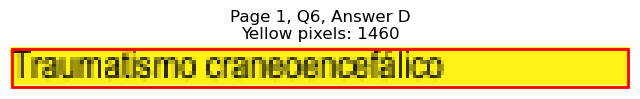


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=147.1, y1=543.9
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 343
Page 1, Q7, A: Yellow percentage: 0.0%


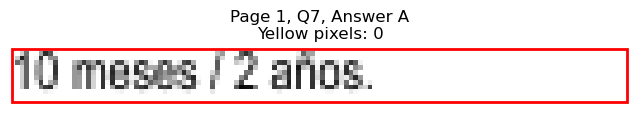

Page 1, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=149.0, y1=556.5
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 369
Page 1, Q7, B: Yellow percentage: 0.0%


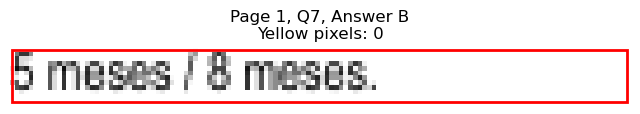

Page 1, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=394.2, y1=543.9
Page 1, Q7, C: Yellow pixels: 1188
Page 1, Q7, C: Total non-white pixels: 1416
Page 1, Q7, C: Yellow percentage: 83.9%


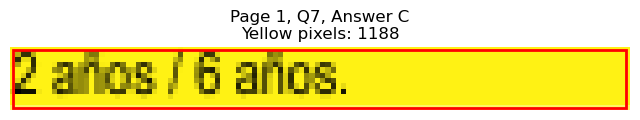

Page 1, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=394.3, y1=556.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 293
Page 1, Q7, D: Yellow percentage: 0.0%


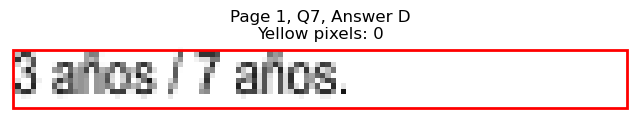


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=322.0, y1=619.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1254
Page 1, Q8, A: Yellow percentage: 0.0%


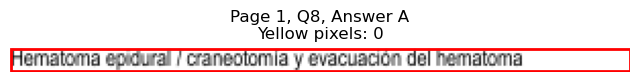

Page 1, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=395.2, y1=632.4
Page 1, Q8, B: Yellow pixels: 378
Page 1, Q8, B: Total non-white pixels: 1958
Page 1, Q8, B: Yellow percentage: 19.3%


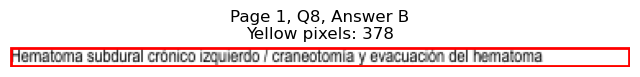

Page 1, Q8 - C: Detected box: x0=68.8, y0=633.9, x1=355.2, y1=645.0
Page 1, Q8, C: Yellow pixels: 2936
Page 1, Q8, C: Total non-white pixels: 4056
Page 1, Q8, C: Yellow percentage: 72.4%


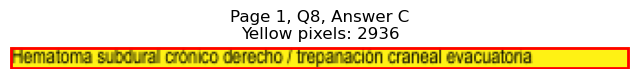

Page 1, Q8 - D: Detected box: x0=68.8, y0=646.5, x1=387.7, y1=657.6
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 1599
Page 1, Q8, D: Yellow percentage: 0.0%


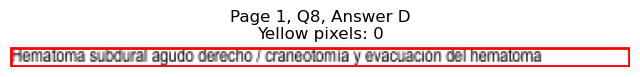


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=376.7, y1=708.1
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 1484
Page 1, Q9, A: Yellow percentage: 0.0%


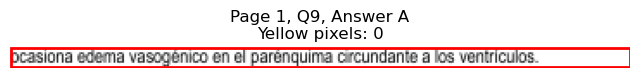

Page 1, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=391.7, y1=720.7
Page 1, Q9, B: Yellow pixels: 374
Page 1, Q9, B: Total non-white pixels: 1999
Page 1, Q9, B: Yellow percentage: 18.7%


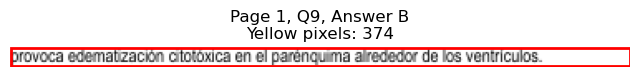

Page 1, Q9 - C: Detected box: x0=68.8, y0=722.2, x1=334.7, y1=733.3
Page 1, Q9, C: Yellow pixels: 2455
Page 1, Q9, C: Total non-white pixels: 3804
Page 1, Q9, C: Yellow percentage: 64.5%


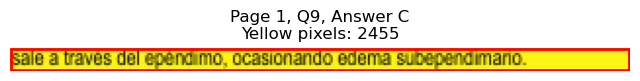

Page 1, Q9 - D: Detected box: x0=68.8, y0=734.8, x1=408.7, y1=745.9
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 1725
Page 1, Q9, D: Yellow percentage: 0.0%


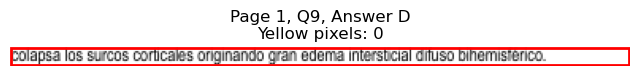


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=421.4, y1=114.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 1724
Page 2, Q1, A: Yellow percentage: 0.0%


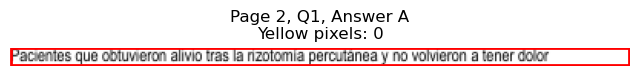

Page 2, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=387.7, y1=127.4
Page 2, Q1, B: Yellow pixels: 370
Page 2, Q1, B: Total non-white pixels: 1978
Page 2, Q1, B: Yellow percentage: 18.7%


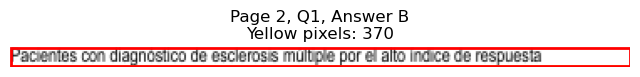

Page 2, Q1 - C: Detected box: x0=68.8, y0=129.0, x1=491.2, y1=140.0
Page 2, Q1, C: Yellow pixels: 4125
Page 2, Q1, C: Total non-white pixels: 5664
Page 2, Q1, C: Yellow percentage: 72.8%


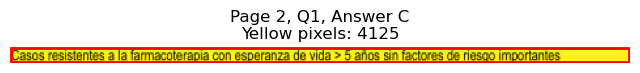

Page 2, Q1 - D: Detected box: x0=68.8, y0=141.7, x1=487.6, y1=152.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 2014
Page 2, Q1, D: Yellow percentage: 0.0%


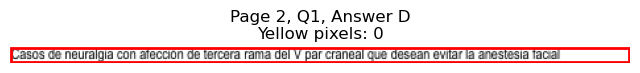


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=320.6, y1=203.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 1235
Page 2, Q2, A: Yellow percentage: 0.0%


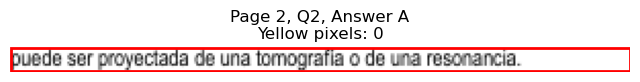

Page 2, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=321.0, y1=215.7
Page 2, Q2, B: Yellow pixels: 4
Page 2, Q2, B: Total non-white pixels: 1517
Page 2, Q2, B: Yellow percentage: 0.3%


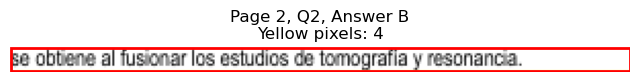

Page 2, Q2 - C: Detected box: x0=68.8, y0=217.4, x1=316.1, y1=228.4
Page 2, Q2, C: Yellow pixels: 2356
Page 2, Q2, C: Total non-white pixels: 3588
Page 2, Q2, C: Yellow percentage: 65.7%


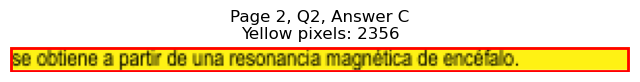

Page 2, Q2 - D: Detected box: x0=68.8, y0=230.0, x1=406.2, y1=241.0
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 1664
Page 2, Q2, D: Yellow percentage: 0.0%


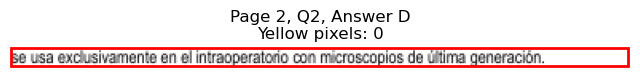


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=81.8, y1=304.2
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 65
Page 2, Q3, A: Yellow percentage: 0.0%


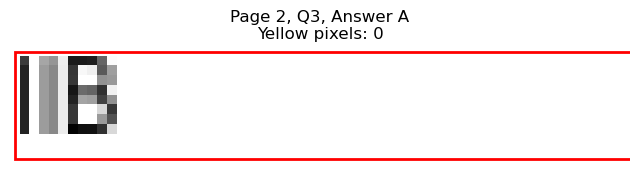

Page 2, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=79.3, y1=316.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 36
Page 2, Q3, B: Yellow percentage: 0.0%


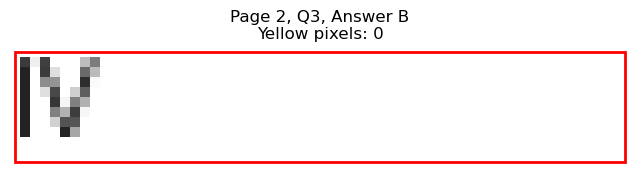

Page 2, Q3 - C: Detected box: x0=327.5, y0=293.1, x1=352.3, y1=304.2
Page 2, Q3, C: Yellow pixels: 737
Page 2, Q3, C: Total non-white pixels: 836
Page 2, Q3, C: Yellow percentage: 88.2%


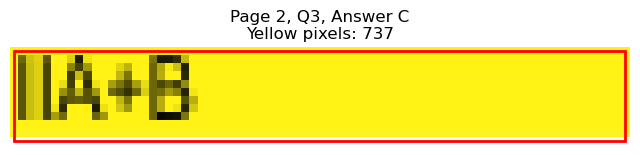

Page 2, Q3 - D: Detected box: x0=327.5, y0=305.7, x1=341.0, y1=316.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 63
Page 2, Q3, D: Yellow percentage: 0.0%


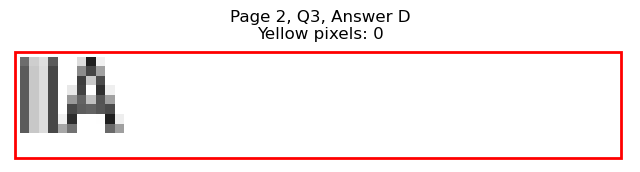


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=382.7, y1=379.9
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 1549
Page 2, Q4, A: Yellow percentage: 0.0%


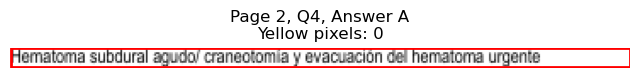

Page 2, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=291.5, y1=392.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 1079
Page 2, Q4, B: Yellow percentage: 0.0%


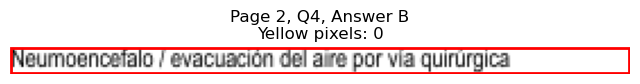

Page 2, Q4 - C: Detected box: x0=68.8, y0=394.0, x1=278.9, y1=405.1
Page 2, Q4, C: Yellow pixels: 261
Page 2, Q4, C: Total non-white pixels: 1568
Page 2, Q4, C: Yellow percentage: 16.6%


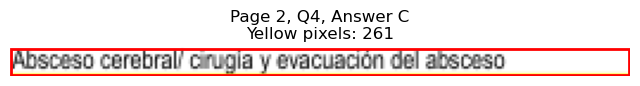

Page 2, Q4 - D: Detected box: x0=68.8, y0=406.6, x1=362.2, y1=417.7
Page 2, Q4, D: Yellow pixels: 3040
Page 2, Q4, D: Total non-white pixels: 4140
Page 2, Q4, D: Yellow percentage: 73.4%


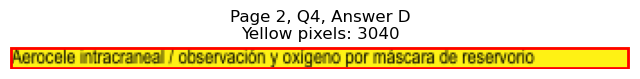


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=457.2, x1=177.2, y1=468.2
Page 2, Q5, A: Yellow pixels: 1375
Page 2, Q5, A: Total non-white pixels: 1765
Page 2, Q5, A: Yellow percentage: 77.9%


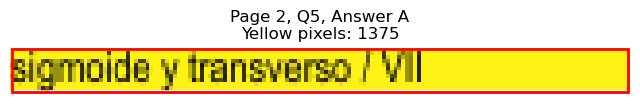

Page 2, Q5 - B: Detected box: x0=68.3, y0=469.8, x1=165.6, y1=480.8
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 463
Page 2, Q5, B: Yellow percentage: 0.0%


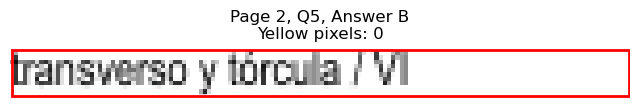

Page 2, Q5 - C: Detected box: x0=327.5, y0=457.2, x1=427.4, y1=468.2
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 460
Page 2, Q5, C: Yellow percentage: 0.0%


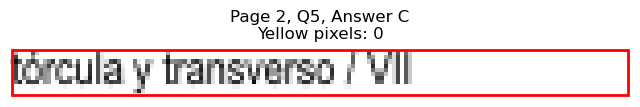

Page 2, Q5 - D: Detected box: x0=327.5, y0=469.8, x1=439.0, y1=480.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 536
Page 2, Q5, D: Yellow percentage: 0.0%


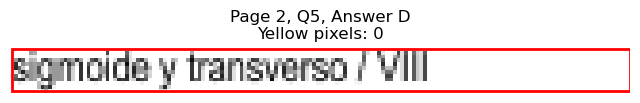


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=532.9, x1=198.2, y1=543.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 630
Page 2, Q6, A: Yellow percentage: 0.0%


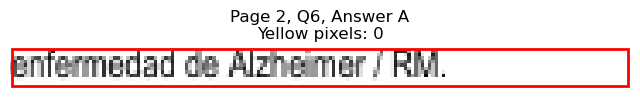

Page 2, Q6 - B: Detected box: x0=68.3, y0=545.5, x1=153.0, y1=556.5
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 409
Page 2, Q6, B: Yellow percentage: 0.0%


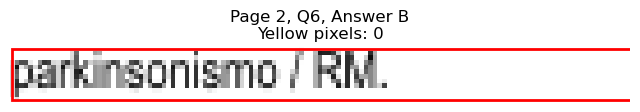

Page 2, Q6 - C: Detected box: x0=327.5, y0=532.9, x1=437.8, y1=543.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 693
Page 2, Q6, C: Yellow percentage: 0.0%


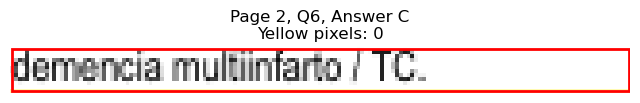

Page 2, Q6 - D: Detected box: x0=327.5, y0=545.5, x1=461.3, y1=556.5
Page 2, Q6, D: Yellow pixels: 1581
Page 2, Q6, D: Total non-white pixels: 2220
Page 2, Q6, D: Yellow percentage: 71.2%


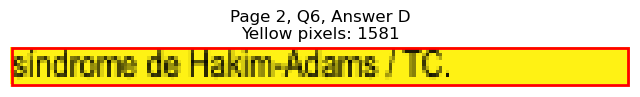


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=359.9, y1=594.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 1424
Page 2, Q7, A: Yellow percentage: 0.0%


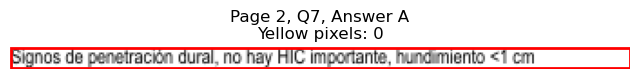

Page 2, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=359.9, y1=607.0
Page 2, Q7, B: Yellow pixels: 342
Page 2, Q7, B: Total non-white pixels: 2104
Page 2, Q7, B: Yellow percentage: 16.3%


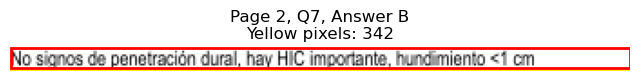

Page 2, Q7 - C: Detected box: x0=68.8, y0=608.6, x1=373.0, y1=619.6
Page 2, Q7, C: Yellow pixels: 3143
Page 2, Q7, C: Total non-white pixels: 4260
Page 2, Q7, C: Yellow percentage: 73.8%


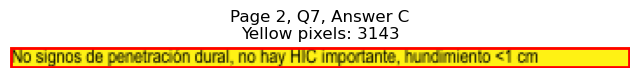

Page 2, Q7 - D: Detected box: x0=68.8, y0=621.3, x1=360.4, y1=632.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 1371
Page 2, Q7, D: Yellow percentage: 0.0%


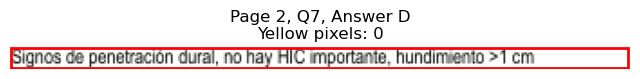


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=697.0, x1=269.9, y1=708.1
Page 2, Q8, A: Yellow pixels: 50
Page 2, Q8, A: Total non-white pixels: 1064
Page 2, Q8, A: Yellow percentage: 4.7%


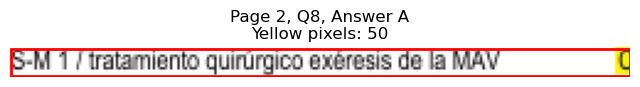

Page 2, Q8 - B: Detected box: x0=68.3, y0=709.6, x1=199.2, y1=720.7
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 610
Page 2, Q8, B: Yellow percentage: 0.0%


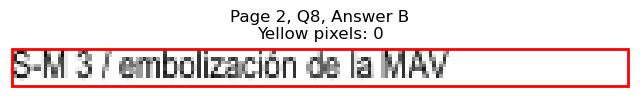

Page 2, Q8 - C: Detected box: x0=327.5, y0=697.0, x1=529.1, y1=708.1
Page 2, Q8, C: Yellow pixels: 1591
Page 2, Q8, C: Total non-white pixels: 2347
Page 2, Q8, C: Yellow percentage: 67.8%


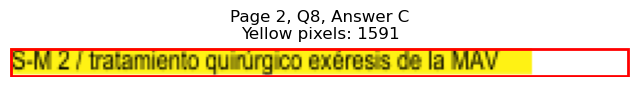

Page 2, Q8 - D: Detected box: x0=327.5, y0=709.6, x1=408.7, y1=720.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 403
Page 2, Q8, D: Yellow percentage: 0.0%


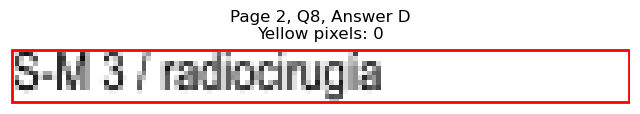


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=747.4, x1=122.9, y1=758.5
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 262
Page 2, Q9, A: Yellow percentage: 0.0%


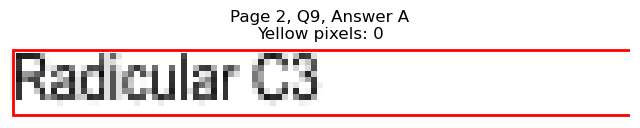

Page 2, Q9 - B: Detected box: x0=68.3, y0=760.2, x1=141.5, y1=771.2
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 375
Page 2, Q9, B: Yellow percentage: 0.0%


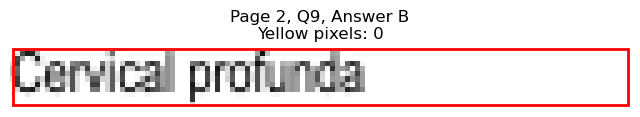

Page 2, Q9 - C: Detected box: x0=327.5, y0=747.4, x1=396.7, y1=758.5
Page 2, Q9, C: Yellow pixels: 1065
Page 2, Q9, C: Total non-white pixels: 1440
Page 2, Q9, C: Yellow percentage: 74.0%


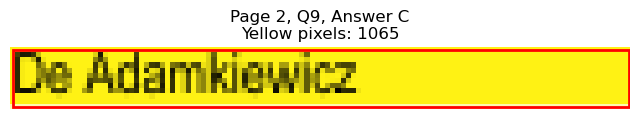

Page 2, Q9 - D: Detected box: x0=327.5, y0=760.2, x1=433.9, y1=771.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 578
Page 2, Q9, D: Yellow percentage: 0.0%


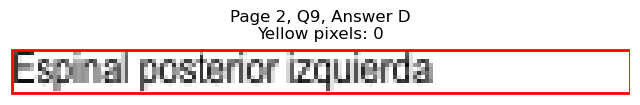


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=162.1, y1=102.2
Page 3, Q1, A: Yellow pixels: 145
Page 3, Q1, A: Total non-white pixels: 738
Page 3, Q1, A: Yellow percentage: 19.6%


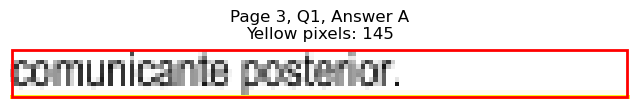

Page 3, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=133.0, y1=114.8
Page 3, Q1, B: Yellow pixels: 1104
Page 3, Q1, B: Total non-white pixels: 1380
Page 3, Q1, B: Yellow percentage: 80.0%


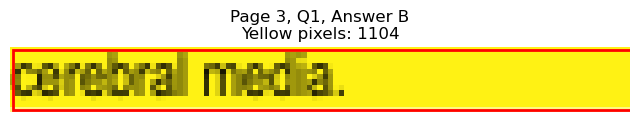

Page 3, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=416.8, y1=102.2
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 423
Page 3, Q1, C: Yellow percentage: 0.0%


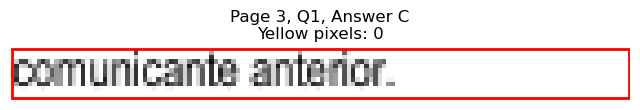

Page 3, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=367.1, y1=114.8
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 197
Page 3, Q1, D: Yellow percentage: 0.0%


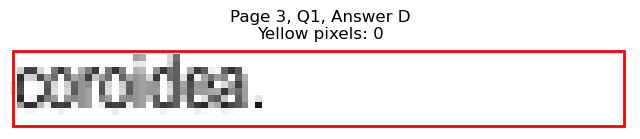


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=255.4, y1=152.7
Page 3, Q2, A: Yellow pixels: 1843
Page 3, Q2, A: Total non-white pixels: 2568
Page 3, Q2, A: Yellow percentage: 71.8%


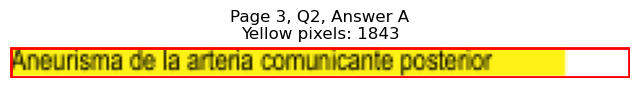

Page 3, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=207.7, y1=165.3
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 714
Page 3, Q2, B: Yellow percentage: 0.0%


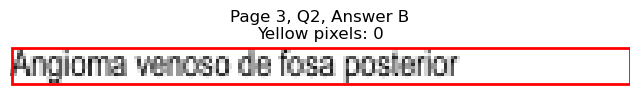

Page 3, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=493.9, y1=152.7
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 858
Page 3, Q2, C: Yellow percentage: 0.0%


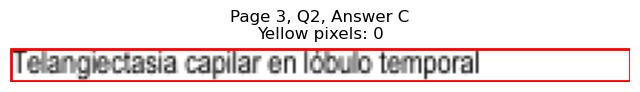

Page 3, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=449.9, y1=165.3
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 633
Page 3, Q2, D: Yellow percentage: 0.0%


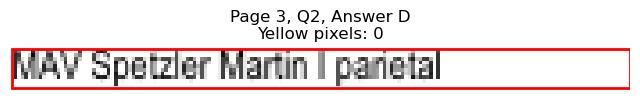


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=131.0, y1=228.4
Page 3, Q3, A: Yellow pixels: 114
Page 3, Q3, A: Total non-white pixels: 357
Page 3, Q3, A: Yellow percentage: 31.9%


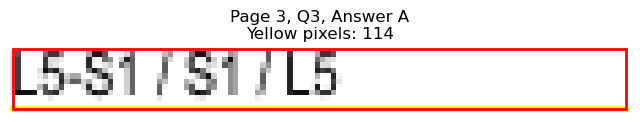

Page 3, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=129.0, y1=241.0
Page 3, Q3, B: Yellow pixels: 1163
Page 3, Q3, B: Total non-white pixels: 1332
Page 3, Q3, B: Yellow percentage: 87.3%


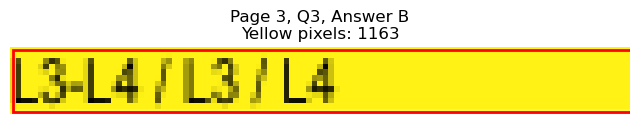

Page 3, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=388.2, y1=228.4
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 218
Page 3, Q3, C: Yellow percentage: 0.0%


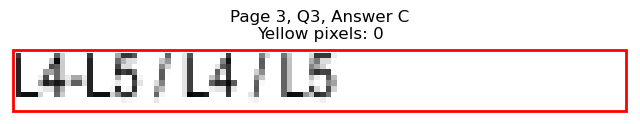

Page 3, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=390.2, y1=241.0
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 234
Page 3, Q3, D: Yellow percentage: 0.0%


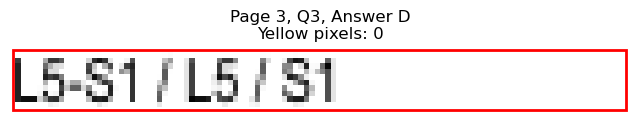


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=385.7, y1=291.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 1486
Page 3, Q4, A: Yellow percentage: 0.0%


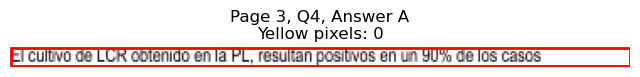

Page 3, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=467.0, y1=304.2
Page 3, Q4, B: Yellow pixels: 450
Page 3, Q4, B: Total non-white pixels: 2831
Page 3, Q4, B: Yellow percentage: 15.9%


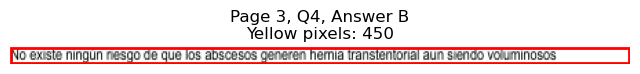

Page 3, Q4 - C: Detected box: x0=68.8, y0=305.7, x1=438.5, y1=316.8
Page 3, Q4, C: Yellow pixels: 3692
Page 3, Q4, C: Total non-white pixels: 5052
Page 3, Q4, C: Yellow percentage: 73.1%


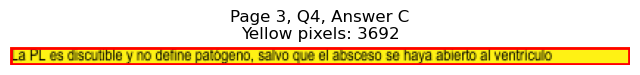

Page 3, Q4 - D: Detected box: x0=68.8, y0=318.3, x1=389.3, y1=329.4
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 1529
Page 3, Q4, D: Yellow percentage: 0.0%


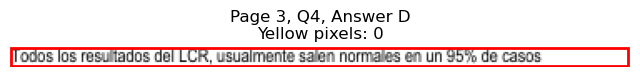


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=133.4, y1=392.5
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 348
Page 3, Q5, A: Yellow percentage: 0.0%


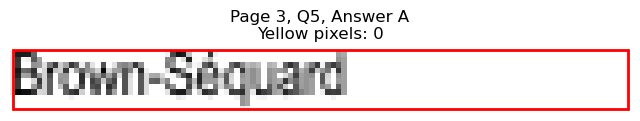

Page 3, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=133.0, y1=405.1
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 294
Page 3, Q5, B: Yellow percentage: 0.0%


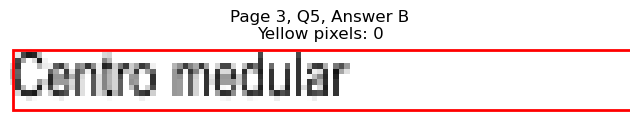

Page 3, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=404.2, y1=392.5
Page 3, Q5, C: Yellow pixels: 128
Page 3, Q5, C: Total non-white pixels: 516
Page 3, Q5, C: Yellow percentage: 24.8%


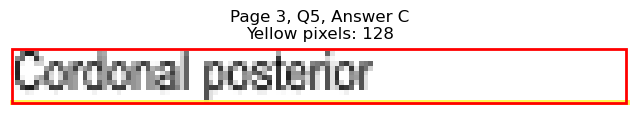

Page 3, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=399.7, y1=405.1
Page 3, Q5, D: Yellow pixels: 1069
Page 3, Q5, D: Total non-white pixels: 1353
Page 3, Q5, D: Yellow percentage: 79.0%


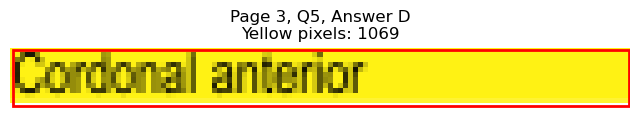


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=90.4, y1=468.2
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 113
Page 3, Q6, A: Yellow percentage: 0.0%


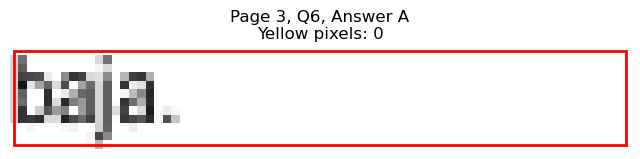

Page 3, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=97.9, y1=480.8
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 147
Page 3, Q6, B: Yellow percentage: 0.0%


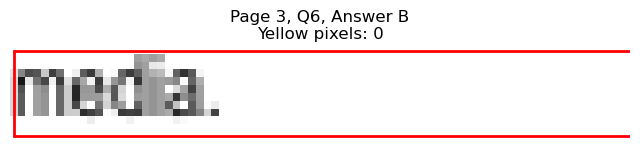

Page 3, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=347.0, y1=468.2
Page 3, Q6, C: Yellow pixels: 718
Page 3, Q6, C: Total non-white pixels: 781
Page 3, Q6, C: Yellow percentage: 91.9%


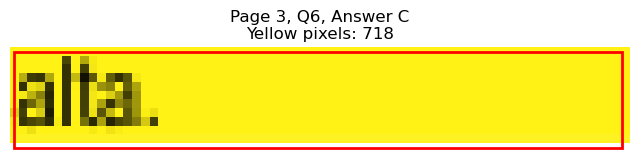

Page 3, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=383.2, y1=480.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 271
Page 3, Q6, D: Yellow percentage: 0.0%


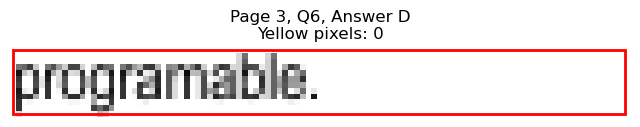


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=168.1, y1=518.7
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 497
Page 3, Q7, A: Yellow percentage: 0.0%


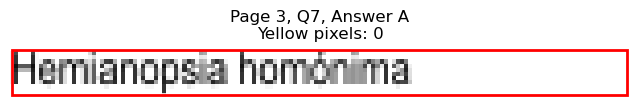

Page 3, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=204.1, y1=531.3
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 681
Page 3, Q7, B: Yellow percentage: 0.0%


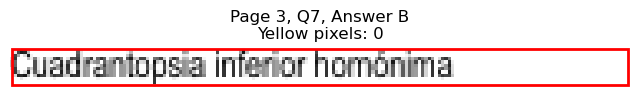

Page 3, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=468.4, y1=518.7
Page 3, Q7, C: Yellow pixels: 192
Page 3, Q7, C: Total non-white pixels: 921
Page 3, Q7, C: Yellow percentage: 20.8%


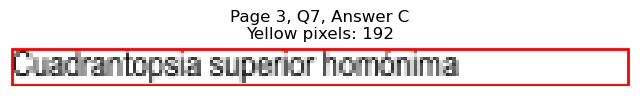

Page 3, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=427.3, y1=531.3
Page 3, Q7, D: Yellow pixels: 1264
Page 3, Q7, D: Total non-white pixels: 1812
Page 3, Q7, D: Yellow percentage: 69.8%


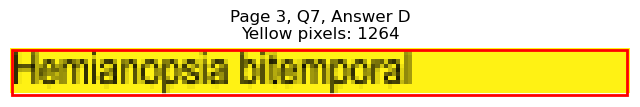


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=289.4, y1=569.2
Page 3, Q8, A: Yellow pixels: 2186
Page 3, Q8, A: Total non-white pixels: 2996
Page 3, Q8, A: Yellow percentage: 73.0%


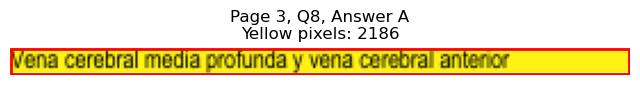

Page 3, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=225.7, y1=581.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 775
Page 3, Q8, B: Yellow percentage: 0.0%


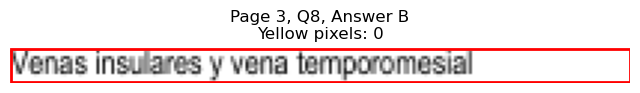

Page 3, Q8 - C: Detected box: x0=68.8, y0=583.4, x1=286.9, y1=594.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 1077
Page 3, Q8, C: Yellow percentage: 0.0%


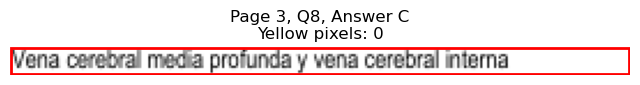

Page 3, Q8 - D: Detected box: x0=68.8, y0=596.0, x1=237.2, y1=607.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 829
Page 3, Q8, D: Yellow percentage: 0.0%


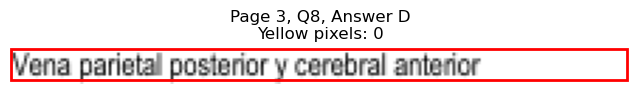


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=142.6, y1=645.0
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 386
Page 3, Q9, A: Yellow percentage: 0.0%


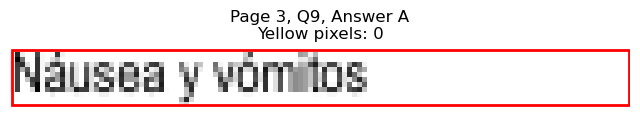

Page 3, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=187.7, y1=657.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 602
Page 3, Q9, B: Yellow percentage: 0.0%


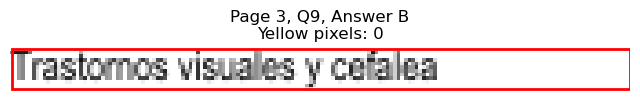

Page 3, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=417.2, y1=645.0
Page 3, Q9, C: Yellow pixels: 1342
Page 3, Q9, C: Total non-white pixels: 1692
Page 3, Q9, C: Yellow percentage: 79.3%


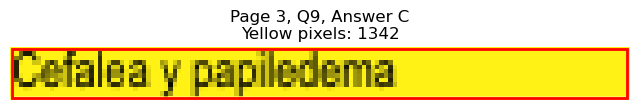

Page 3, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=433.8, y1=657.6
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 541
Page 3, Q9, D: Yellow percentage: 0.0%


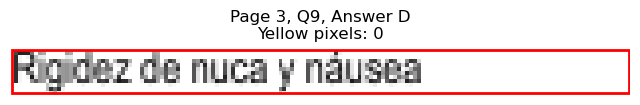


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=228.2, y1=733.3
Page 3, Q10, A: Yellow pixels: 211
Page 3, Q10, A: Total non-white pixels: 1001
Page 3, Q10, A: Yellow percentage: 21.1%


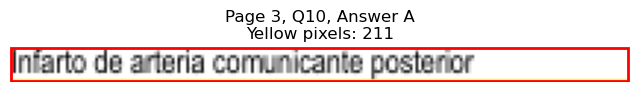

Page 3, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=207.1, y1=745.9
Page 3, Q10, B: Yellow pixels: 1787
Page 3, Q10, B: Total non-white pixels: 2280
Page 3, Q10, B: Yellow percentage: 78.4%


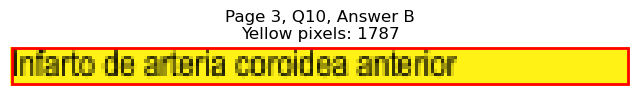

Page 3, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=387.1, y1=733.3
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 309
Page 3, Q10, C: Yellow percentage: 0.0%


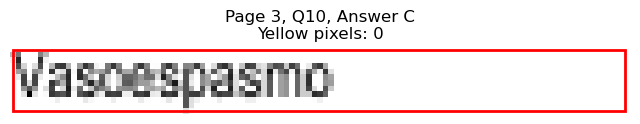

Page 3, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=450.0, y1=745.9
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 622
Page 3, Q10, D: Yellow percentage: 0.0%


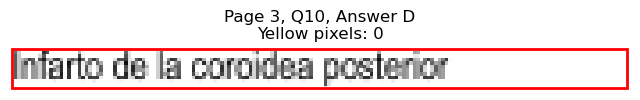


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=167.0, y1=140.0
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 465
Page 4, Q1, A: Yellow percentage: 0.0%


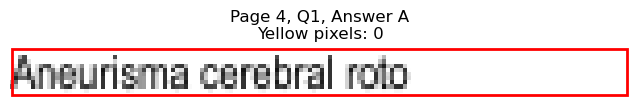

Page 4, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=161.0, y1=152.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 431
Page 4, Q1, B: Yellow percentage: 0.0%


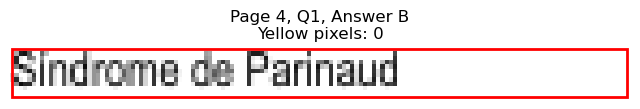

Page 4, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=413.3, y1=140.0
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 591
Page 4, Q1, C: Yellow percentage: 0.0%


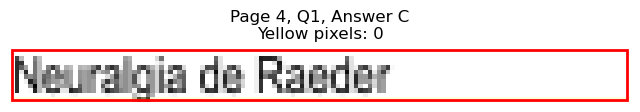

Page 4, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=432.8, y1=152.7
Page 4, Q1, D: Yellow pixels: 1467
Page 4, Q1, D: Total non-white pixels: 1872
Page 4, Q1, D: Yellow percentage: 78.4%


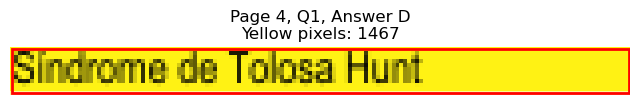


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=111.4, y1=203.1
Page 4, Q2, A: Yellow pixels: 866
Page 4, Q2, A: Total non-white pixels: 1034
Page 4, Q2, A: Yellow percentage: 83.8%


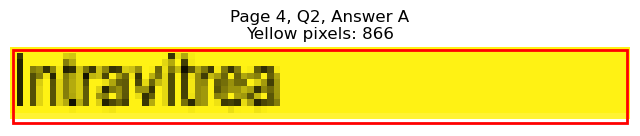

Page 4, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=123.0, y1=215.7
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 285
Page 4, Q2, B: Yellow percentage: 0.0%


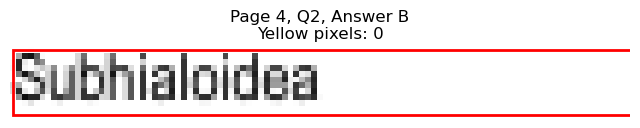

Page 4, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=381.6, y1=203.1
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 279
Page 4, Q2, C: Yellow percentage: 0.0%


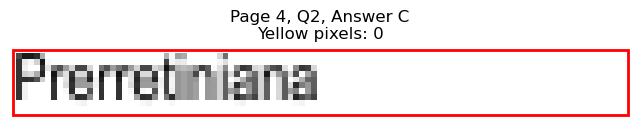

Page 4, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=385.7, y1=215.7
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 306
Page 4, Q2, D: Yellow percentage: 0.0%


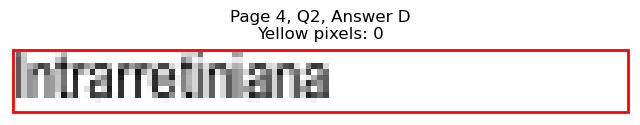


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=159.5, y1=278.8
Page 4, Q3, A: Yellow pixels: 1373
Page 4, Q3, A: Total non-white pixels: 1704
Page 4, Q3, A: Yellow percentage: 80.6%


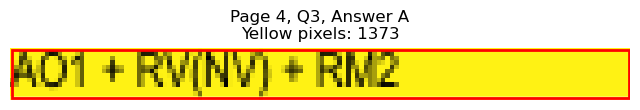

Page 4, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=146.0, y1=291.6
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 335
Page 4, Q3, B: Yellow percentage: 0.0%


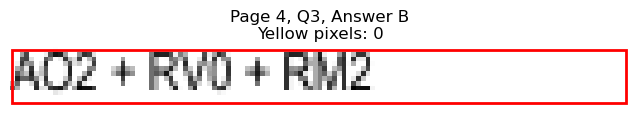

Page 4, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=405.2, y1=278.8
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 332
Page 4, Q3, C: Yellow percentage: 0.0%


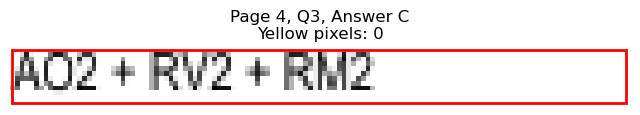

Page 4, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=418.7, y1=291.6
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 385
Page 4, Q3, D: Yellow percentage: 0.0%


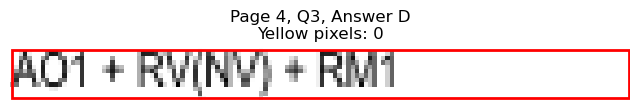


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=77.3, y1=329.4
Page 4, Q4, A: Yellow pixels: 60
Page 4, Q4, A: Total non-white pixels: 94
Page 4, Q4, A: Yellow percentage: 63.8%


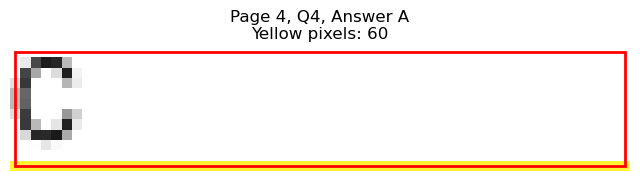

Page 4, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=76.8, y1=342.0
Page 4, Q4, B: Yellow pixels: 683
Page 4, Q4, B: Total non-white pixels: 708
Page 4, Q4, B: Yellow percentage: 96.5%


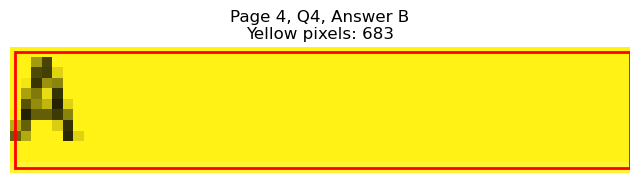

Page 4, Q4 - C: Detected box: x0=315.4, y0=318.3, x1=324.4, y1=329.4
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 70
Page 4, Q4, C: Yellow percentage: 0.0%


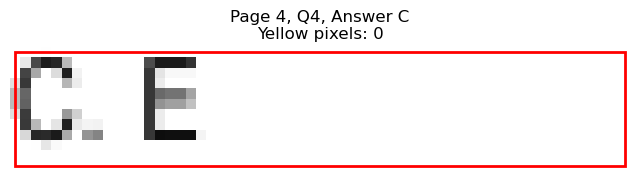

Page 4, Q4 - D: Detected box: x0=315.4, y0=330.9, x1=324.4, y1=342.0
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 79
Page 4, Q4, D: Yellow percentage: 0.0%


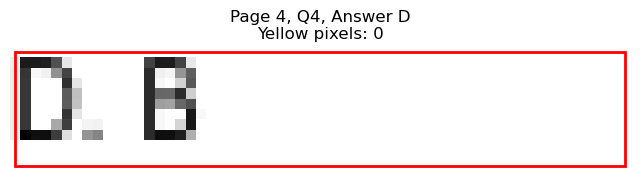


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=176.8, y1=405.1
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 535
Page 4, Q5, A: Yellow percentage: 0.0%


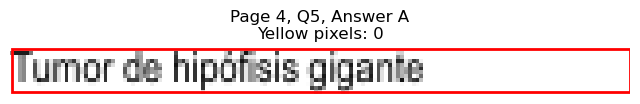

Page 4, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=158.2, y1=417.7
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 431
Page 4, Q5, B: Yellow percentage: 0.0%


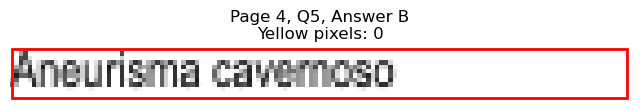

Page 4, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=397.2, y1=405.1
Page 4, Q5, C: Yellow pixels: 121
Page 4, Q5, C: Total non-white pixels: 562
Page 4, Q5, C: Yellow percentage: 21.5%


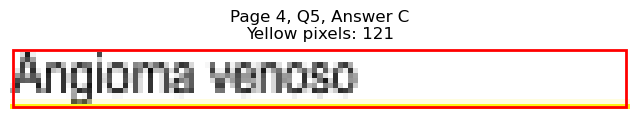

Page 4, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=465.8, y1=417.7
Page 4, Q5, D: Yellow pixels: 1741
Page 4, Q5, D: Total non-white pixels: 2268
Page 4, Q5, D: Yellow percentage: 76.8%


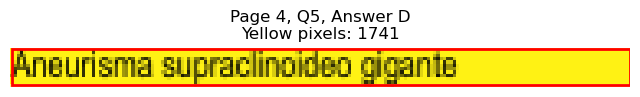


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=321.1, y1=480.8
Page 4, Q6, A: Yellow pixels: 2684
Page 4, Q6, A: Total non-white pixels: 3648
Page 4, Q6, A: Yellow percentage: 73.6%


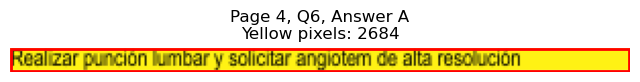

Page 4, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=193.2, y1=493.5
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 583
Page 4, Q6, B: Yellow percentage: 0.0%


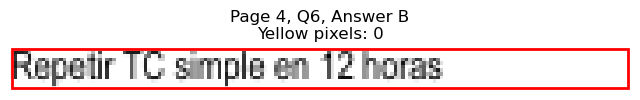

Page 4, Q6 - C: Detected box: x0=68.8, y0=495.1, x1=263.9, y1=506.1
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 962
Page 4, Q6, C: Yellow percentage: 0.0%


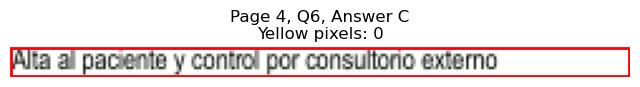

Page 4, Q6 - D: Detected box: x0=68.8, y0=507.7, x1=183.6, y1=518.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 573
Page 4, Q6, D: Yellow percentage: 0.0%


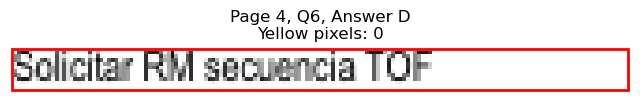


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=88.8, y1=581.8
Page 4, Q7, A: Yellow pixels: 807
Page 4, Q7, A: Total non-white pixels: 852
Page 4, Q7, A: Yellow percentage: 94.7%


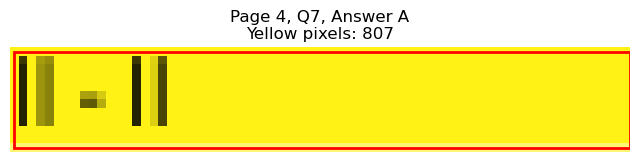

Page 4, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=88.8, y1=594.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 54
Page 4, Q7, B: Yellow percentage: 0.0%


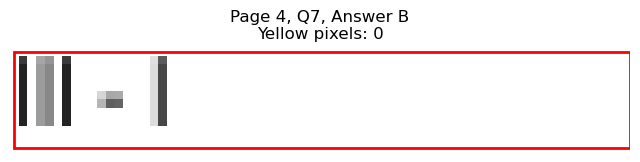

Page 4, Q7 - C: Detected box: x0=327.5, y0=570.8, x1=350.5, y1=581.8
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 86
Page 4, Q7, C: Yellow percentage: 0.0%


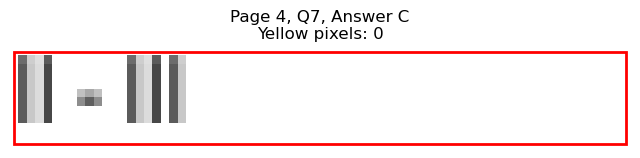

Page 4, Q7 - D: Detected box: x0=327.5, y0=583.4, x1=348.0, y1=594.4
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 72
Page 4, Q7, D: Yellow percentage: 0.0%


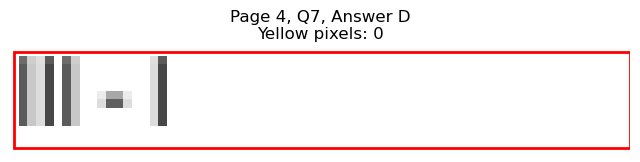


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=189.6, y1=645.0
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 782
Page 4, Q8, A: Yellow percentage: 0.0%


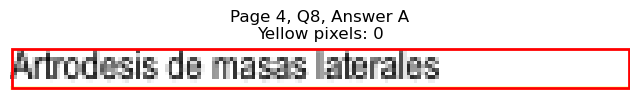

Page 4, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=257.8, y1=657.6
Page 4, Q8, B: Yellow pixels: 1656
Page 4, Q8, B: Total non-white pixels: 2568
Page 4, Q8, B: Yellow percentage: 64.5%


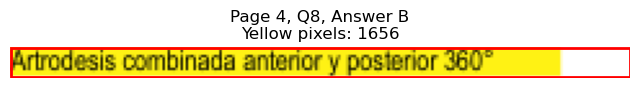

Page 4, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=541.1, y1=645.0
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 1046
Page 4, Q8, C: Yellow percentage: 0.0%


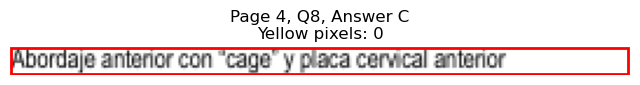

Page 4, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=453.8, y1=657.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 631
Page 4, Q8, D: Yellow percentage: 0.0%


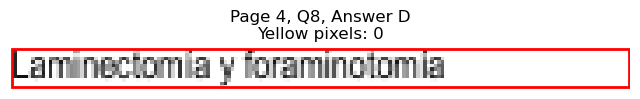


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=111.4, y1=708.1
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 225
Page 4, Q9, A: Yellow percentage: 0.0%


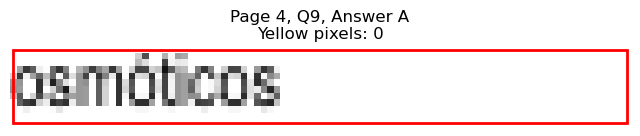

Page 4, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=147.5, y1=720.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 414
Page 4, Q9, B: Yellow percentage: 0.0%


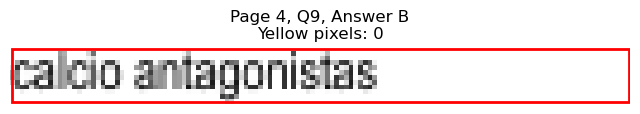

Page 4, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=373.1, y1=708.1
Page 4, Q9, C: Yellow pixels: 882
Page 4, Q9, C: Total non-white pixels: 1067
Page 4, Q9, C: Yellow percentage: 82.7%


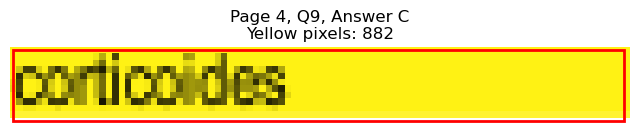

Page 4, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=375.1, y1=720.7
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 257
Page 4, Q9, D: Yellow percentage: 0.0%


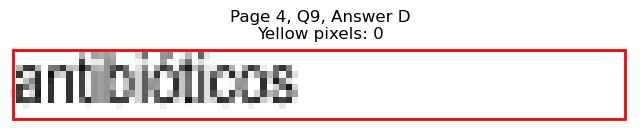


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=313.6, y1=127.4
Page 5, Q1, A: Yellow pixels: 296
Page 5, Q1, A: Total non-white pixels: 1559
Page 5, Q1, A: Yellow percentage: 19.0%


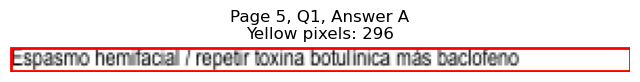

Page 5, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=322.1, y1=140.0
Page 5, Q1, B: Yellow pixels: 2688
Page 5, Q1, B: Total non-white pixels: 3660
Page 5, Q1, B: Yellow percentage: 73.4%


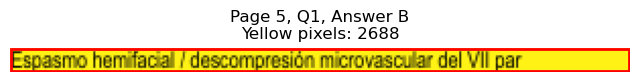

Page 5, Q1 - C: Detected box: x0=68.8, y0=141.7, x1=329.5, y1=152.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 1303
Page 5, Q1, C: Yellow percentage: 0.0%


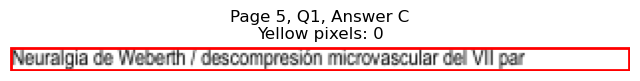

Page 5, Q1 - D: Detected box: x0=68.8, y0=154.3, x1=319.9, y1=165.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 1263
Page 5, Q1, D: Yellow percentage: 0.0%


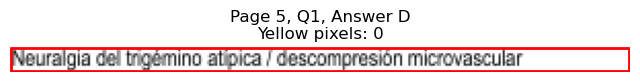


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=124.4, y1=203.1
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 285
Page 5, Q2, A: Yellow percentage: 0.0%


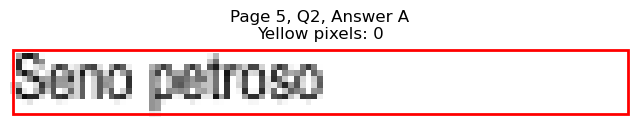

Page 5, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=174.1, y1=215.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 544
Page 5, Q2, B: Yellow percentage: 0.0%


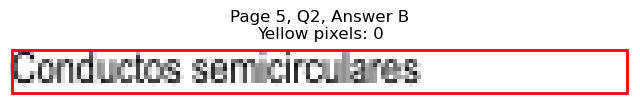

Page 5, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=407.3, y1=203.1
Page 5, Q2, C: Yellow pixels: 1165
Page 5, Q2, C: Total non-white pixels: 1445
Page 5, Q2, C: Yellow percentage: 80.6%


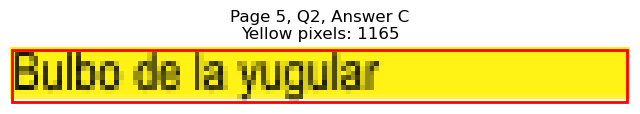

Page 5, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=427.8, y1=215.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 472
Page 5, Q2, D: Yellow percentage: 0.0%


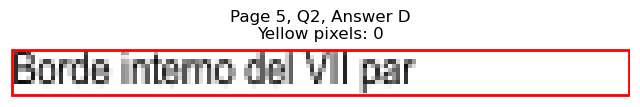


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=144.0, y1=278.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 394
Page 5, Q3, A: Yellow percentage: 0.0%


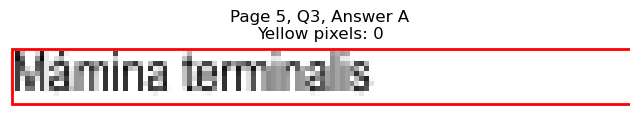

Page 5, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=126.5, y1=291.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 282
Page 5, Q3, B: Yellow percentage: 0.0%


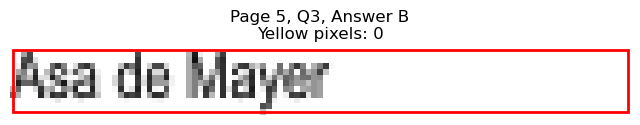

Page 5, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=423.2, y1=278.8
Page 5, Q3, C: Yellow pixels: 1403
Page 5, Q3, C: Total non-white pixels: 1764
Page 5, Q3, C: Yellow percentage: 79.5%


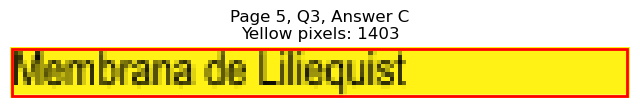

Page 5, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=400.2, y1=291.6
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 378
Page 5, Q3, D: Yellow percentage: 0.0%


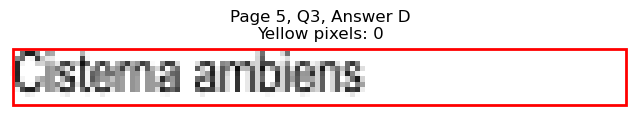


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=175.1, y1=342.0
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 569
Page 5, Q4, A: Yellow percentage: 0.0%


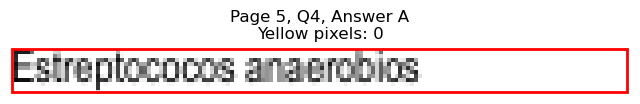

Page 5, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=124.0, y1=354.7
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 308
Page 5, Q4, B: Yellow percentage: 0.0%


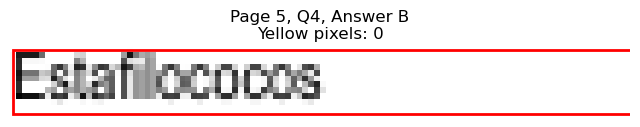

Page 5, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=457.8, y1=342.0
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 876
Page 5, Q4, C: Yellow percentage: 0.0%


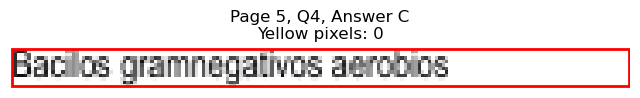

Page 5, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=424.3, y1=354.7
Page 5, Q4, D: Yellow pixels: 1407
Page 5, Q4, D: Total non-white pixels: 1776
Page 5, Q4, D: Yellow percentage: 79.2%


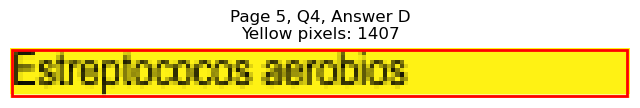


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=333.5, y1=405.1
Page 5, Q5, A: Yellow pixels: 316
Page 5, Q5, A: Total non-white pixels: 1913
Page 5, Q5, A: Yellow percentage: 16.5%


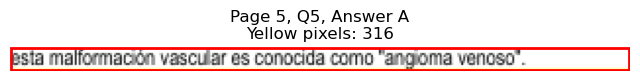

Page 5, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=300.0, y1=417.7
Page 5, Q5, B: Yellow pixels: 2503
Page 5, Q5, B: Total non-white pixels: 3384
Page 5, Q5, B: Yellow percentage: 74.0%


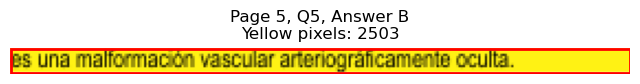

Page 5, Q5 - C: Detected box: x0=68.8, y0=419.4, x1=340.1, y1=430.4
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 1348
Page 5, Q5, C: Yellow percentage: 0.0%


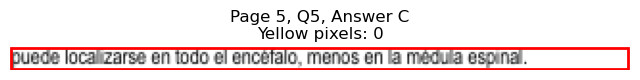

Page 5, Q5 - D: Detected box: x0=68.8, y0=432.0, x1=320.0, y1=443.0
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 1205
Page 5, Q5, D: Yellow percentage: 0.0%


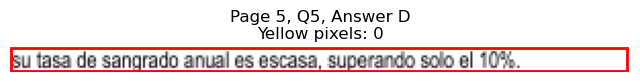


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=495.1, x1=188.6, y1=506.1
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 574
Page 5, Q6, A: Yellow percentage: 0.0%


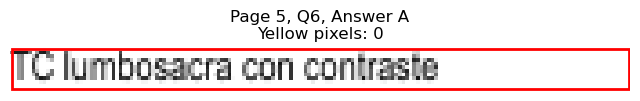

Page 5, Q6 - B: Detected box: x0=68.3, y0=507.7, x1=247.2, y1=518.7
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 870
Page 5, Q6, B: Yellow percentage: 0.0%


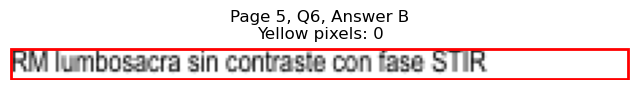

Page 5, Q6 - C: Detected box: x0=327.5, y0=495.1, x1=509.5, y1=506.1
Page 5, Q6, C: Yellow pixels: 1652
Page 5, Q6, C: Total non-white pixels: 2343
Page 5, Q6, C: Yellow percentage: 70.5%


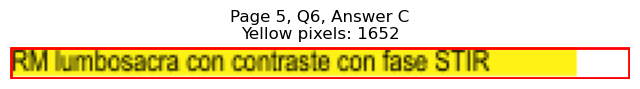

Page 5, Q6 - D: Detected box: x0=327.5, y0=507.7, x1=428.8, y1=518.7
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 503
Page 5, Q6, D: Yellow percentage: 0.0%


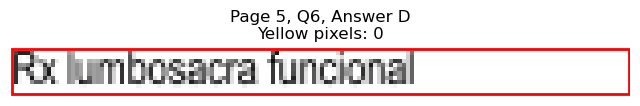


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=352.7, y1=556.5
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 1389
Page 5, Q7, A: Yellow percentage: 0.0%


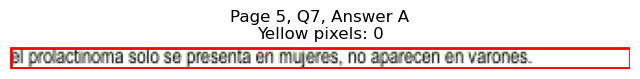

Page 5, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=356.6, y1=569.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 1486
Page 5, Q7, B: Yellow percentage: 0.0%


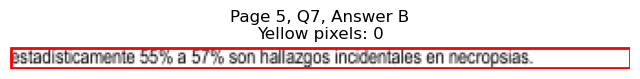

Page 5, Q7 - C: Detected box: x0=68.8, y0=570.8, x1=385.2, y1=581.8
Page 5, Q7, C: Yellow pixels: 8
Page 5, Q7, C: Total non-white pixels: 1984
Page 5, Q7, C: Yellow percentage: 0.4%


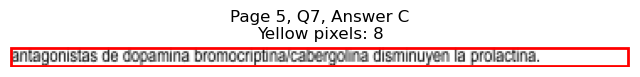

Page 5, Q7 - D: Detected box: x0=68.8, y0=583.4, x1=361.6, y1=594.4
Page 5, Q7, D: Yellow pixels: 2687
Page 5, Q7, D: Total non-white pixels: 4128
Page 5, Q7, D: Yellow percentage: 65.1%


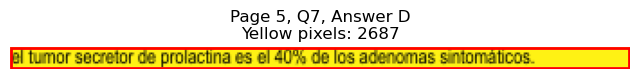


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=130.0, y1=657.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 309
Page 5, Q8, A: Yellow percentage: 0.0%


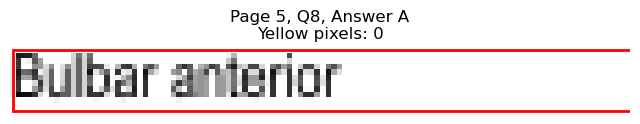

Page 5, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=133.9, y1=670.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 329
Page 5, Q8, B: Yellow percentage: 0.0%


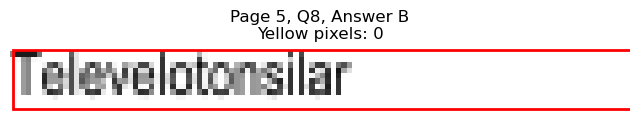

Page 5, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=383.2, y1=657.6
Page 5, Q8, C: Yellow pixels: 969
Page 5, Q8, C: Total non-white pixels: 1284
Page 5, Q8, C: Yellow percentage: 75.5%


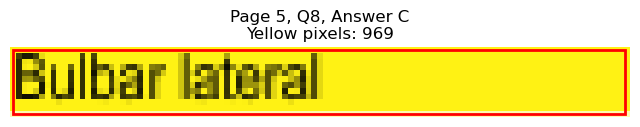

Page 5, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=360.6, y1=670.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 169
Page 5, Q8, D: Yellow percentage: 0.0%


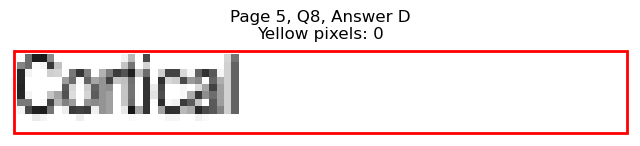


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=151.1, y1=708.1
Page 5, Q9, A: Yellow pixels: 134
Page 5, Q9, A: Total non-white pixels: 706
Page 5, Q9, A: Yellow percentage: 19.0%


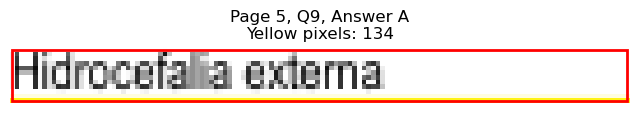

Page 5, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=205.2, y1=720.7
Page 5, Q9, B: Yellow pixels: 1716
Page 5, Q9, B: Total non-white pixels: 2256
Page 5, Q9, B: Yellow percentage: 76.1%


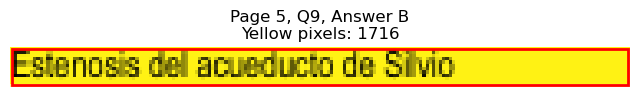

Page 5, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=422.8, y1=708.1
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 499
Page 5, Q9, C: Yellow percentage: 0.0%


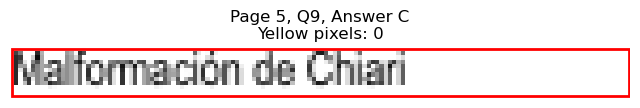

Page 5, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=402.7, y1=720.7
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 411
Page 5, Q9, D: Yellow percentage: 0.0%


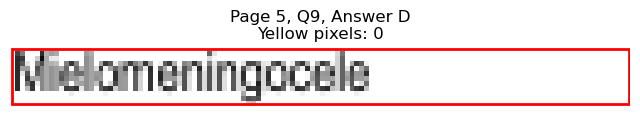


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=267.4, y1=114.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 964
Page 6, Q1, A: Yellow percentage: 0.0%


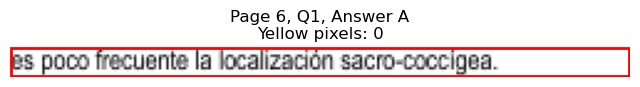

Page 6, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=270.4, y1=127.4
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 1028
Page 6, Q1, B: Yellow percentage: 0.0%


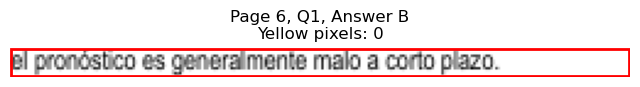

Page 6, Q1 - C: Detected box: x0=68.8, y0=129.0, x1=442.4, y1=140.0
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 2353
Page 6, Q1, C: Yellow percentage: 0.0%


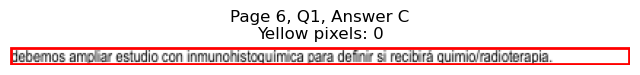

Page 6, Q1 - D: Detected box: x0=68.8, y0=141.7, x1=401.8, y1=152.7
Page 6, Q1, D: Yellow pixels: 3363
Page 6, Q1, D: Total non-white pixels: 4608
Page 6, Q1, D: Yellow percentage: 73.0%


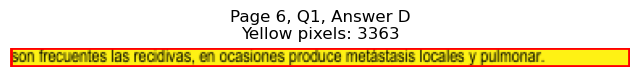


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=310.6, y1=215.7
Page 6, Q2, A: Yellow pixels: 2592
Page 6, Q2, A: Total non-white pixels: 3516
Page 6, Q2, A: Yellow percentage: 73.7%


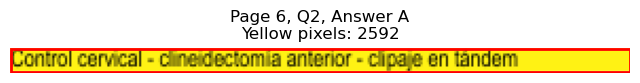

Page 6, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=295.9, y1=228.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 1097
Page 6, Q2, B: Yellow percentage: 0.0%


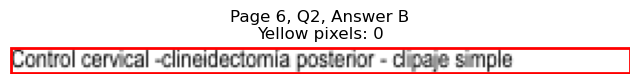

Page 6, Q2 - C: Detected box: x0=68.8, y0=230.0, x1=242.8, y1=241.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 888
Page 6, Q2, C: Yellow percentage: 0.0%


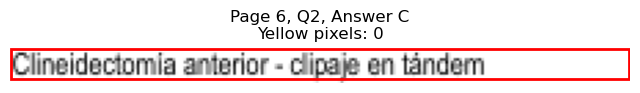

Page 6, Q2 - D: Detected box: x0=68.8, y0=242.6, x1=247.2, y1=253.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 915
Page 6, Q2, D: Yellow percentage: 0.0%


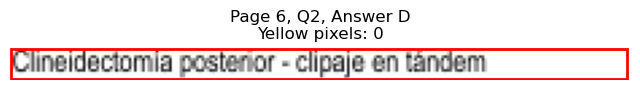


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=211.2, y1=291.6
Page 6, Q3, A: Yellow pixels: 1593
Page 6, Q3, A: Total non-white pixels: 2328
Page 6, Q3, A: Yellow percentage: 68.4%


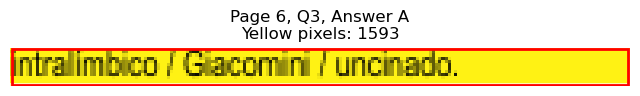

Page 6, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=183.1, y1=304.2
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 552
Page 6, Q3, B: Yellow percentage: 0.0%


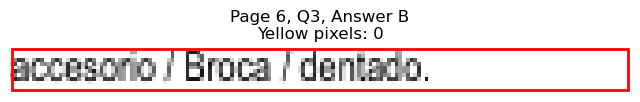

Page 6, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=508.0, y1=291.6
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 907
Page 6, Q3, C: Yellow percentage: 0.0%


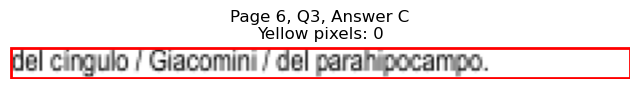

Page 6, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=466.3, y1=304.2
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 681
Page 6, Q3, D: Yellow percentage: 0.0%


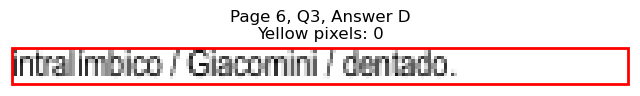


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=149.5, y1=367.3
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 404
Page 6, Q4, A: Yellow percentage: 0.0%


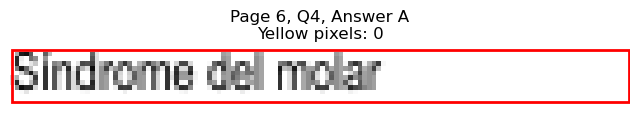

Page 6, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=139.0, y1=379.9
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 348
Page 6, Q4, B: Yellow percentage: 0.0%


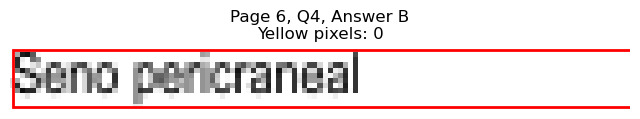

Page 6, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=472.4, y1=367.3
Page 6, Q4, C: Yellow pixels: 1595
Page 6, Q4, C: Total non-white pixels: 2352
Page 6, Q4, C: Yellow percentage: 67.8%


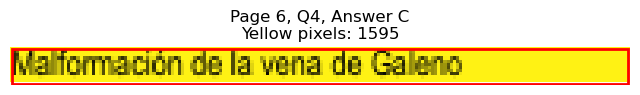

Page 6, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=425.8, y1=379.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 496
Page 6, Q4, D: Yellow percentage: 0.0%


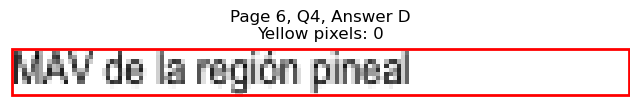


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=150.0, y1=417.7
Page 6, Q5, A: Yellow pixels: 132
Page 6, Q5, A: Total non-white pixels: 549
Page 6, Q5, A: Yellow percentage: 24.0%


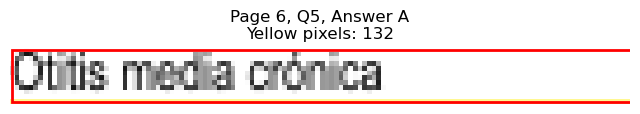

Page 6, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=174.1, y1=430.4
Page 6, Q5, B: Yellow pixels: 1311
Page 6, Q5, B: Total non-white pixels: 1884
Page 6, Q5, B: Yellow percentage: 69.6%


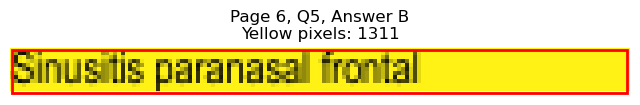

Page 6, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=450.8, y1=417.7
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 650
Page 6, Q5, C: Yellow percentage: 0.0%


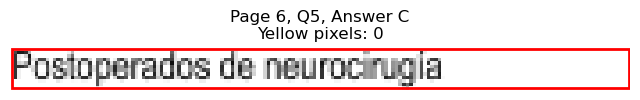

Page 6, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=419.3, y1=430.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 469
Page 6, Q5, D: Yellow percentage: 0.0%


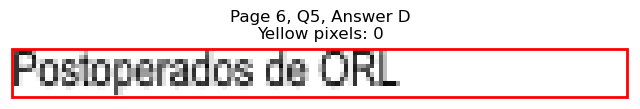


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=149.5, y1=468.2
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 404
Page 6, Q6, A: Yellow percentage: 0.0%


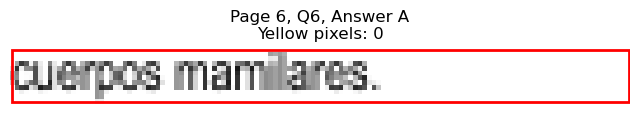

Page 6, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=191.6, y1=480.8
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 620
Page 6, Q6, B: Yellow percentage: 0.0%


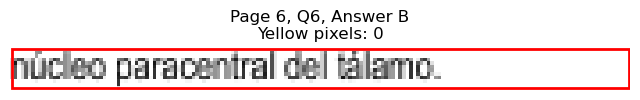

Page 6, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=413.3, y1=468.2
Page 6, Q6, C: Yellow pixels: 137
Page 6, Q6, C: Total non-white pixels: 696
Page 6, Q6, C: Yellow percentage: 19.7%


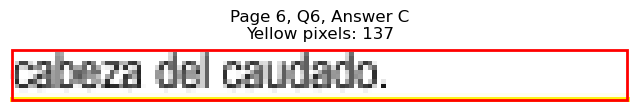

Page 6, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=390.7, y1=480.8
Page 6, Q6, D: Yellow pixels: 1131
Page 6, Q6, D: Total non-white pixels: 1368
Page 6, Q6, D: Yellow percentage: 82.7%


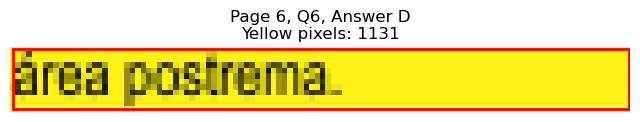


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=325.2, y1=518.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 1276
Page 6, Q7, A: Yellow percentage: 0.0%


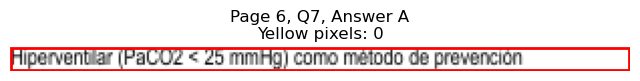

Page 6, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=312.0, y1=531.3
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 1220
Page 6, Q7, B: Yellow percentage: 0.0%


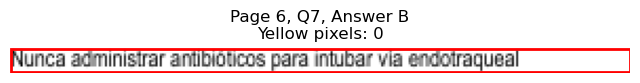

Page 6, Q7 - C: Detected box: x0=68.8, y0=532.9, x1=322.6, y1=543.9
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 1595
Page 6, Q7, C: Yellow percentage: 0.0%


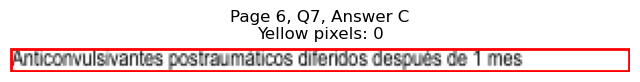

Page 6, Q7 - D: Detected box: x0=68.8, y0=545.5, x1=258.4, y1=556.5
Page 6, Q7, D: Yellow pixels: 1950
Page 6, Q7, D: Total non-white pixels: 2892
Page 6, Q7, D: Yellow percentage: 67.4%


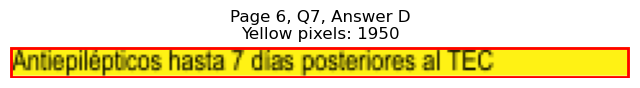


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=221.2, y1=619.6
Page 6, Q8, A: Yellow pixels: 1864
Page 6, Q8, A: Total non-white pixels: 2448
Page 6, Q8, A: Yellow percentage: 76.1%


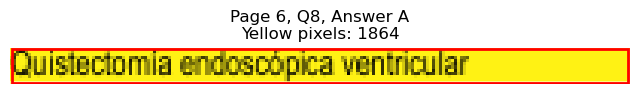

Page 6, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=155.0, y1=632.4
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 433
Page 6, Q8, B: Yellow percentage: 0.0%


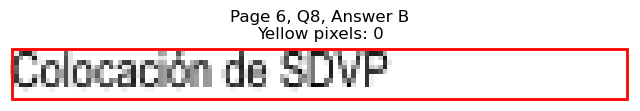

Page 6, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=441.4, y1=619.6
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 573
Page 6, Q8, C: Yellow percentage: 0.0%


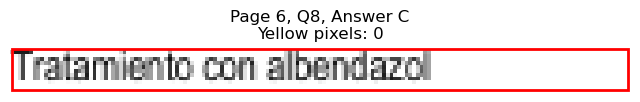

Page 6, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=431.8, y1=632.4
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 543
Page 6, Q8, D: Yellow percentage: 0.0%


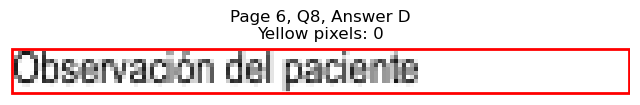


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=78.4, y1=708.1
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 32
Page 6, Q9, A: Yellow percentage: 0.0%


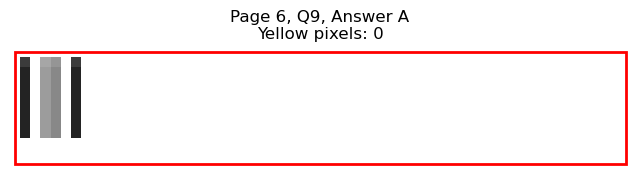

Page 6, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=84.4, y1=720.7
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 62
Page 6, Q9, B: Yellow percentage: 0.0%


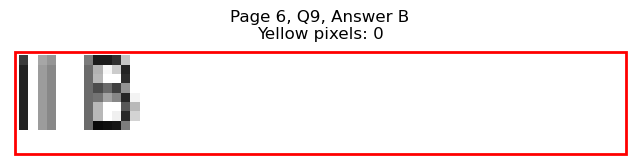

Page 6, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=343.6, y1=708.1
Page 6, Q9, C: Yellow pixels: 685
Page 6, Q9, C: Total non-white pixels: 737
Page 6, Q9, C: Yellow percentage: 92.9%


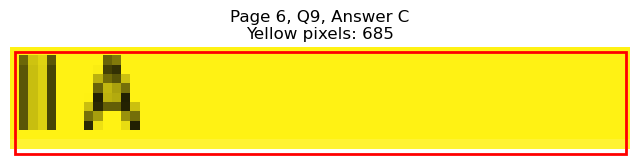

Page 6, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=338.5, y1=720.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 43
Page 6, Q9, D: Yellow percentage: 0.0%


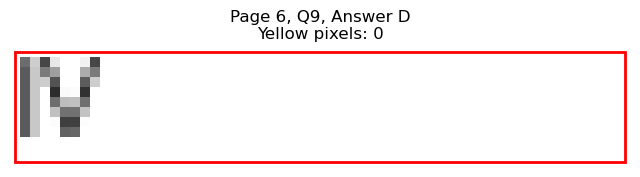


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=245.8, y1=758.5
Page 6, Q10, A: Yellow pixels: 213
Page 6, Q10, A: Total non-white pixels: 1129
Page 6, Q10, A: Yellow percentage: 18.9%


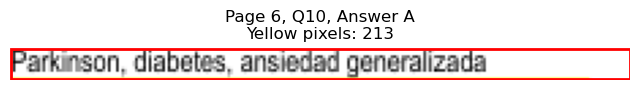

Page 6, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=188.2, y1=771.2
Page 6, Q10, B: Yellow pixels: 1433
Page 6, Q10, B: Total non-white pixels: 1885
Page 6, Q10, B: Yellow percentage: 76.0%


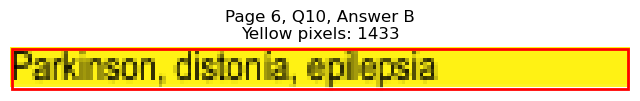

Page 6, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=482.0, y1=758.5
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 750
Page 6, Q10, C: Yellow percentage: 0.0%


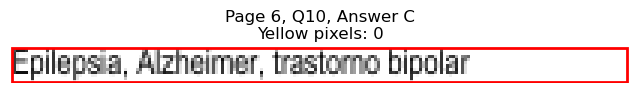

Page 6, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=517.0, y1=771.2
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 922
Page 6, Q10, D: Yellow percentage: 0.0%


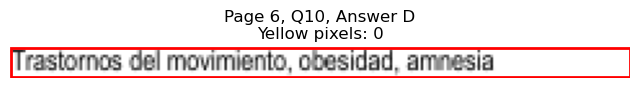


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=483.5, y1=114.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 2081
Page 7, Q1, A: Yellow percentage: 0.0%


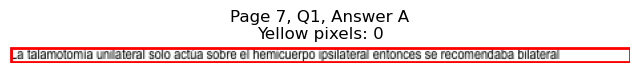

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=541.1, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 2249
Page 7, Q1, B: Yellow percentage: 0.0%


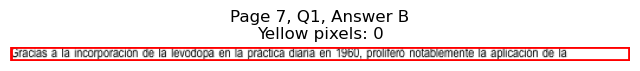

Page 7, Q1 - C: Detected box: x0=68.8, y0=141.7, x1=471.0, y1=152.7
Page 7, Q1, C: Yellow pixels: 3910
Page 7, Q1, C: Total non-white pixels: 5436
Page 7, Q1, C: Yellow percentage: 71.9%


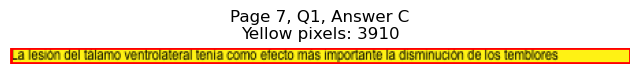

Page 7, Q1 - D: Detected box: x0=68.8, y0=154.3, x1=541.1, y1=165.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 2237
Page 7, Q1, D: Yellow percentage: 0.0%


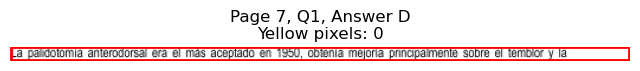


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=96.8, y1=215.7
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 128
Page 7, Q2, A: Yellow percentage: 0.0%


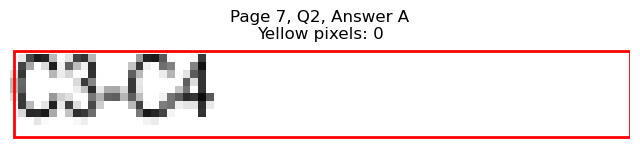

Page 7, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=96.8, y1=228.4
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 131
Page 7, Q2, B: Yellow percentage: 0.0%


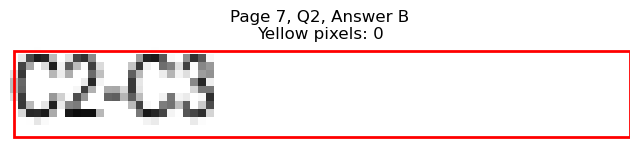

Page 7, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=356.0, y1=215.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 224
Page 7, Q2, C: Yellow percentage: 0.0%


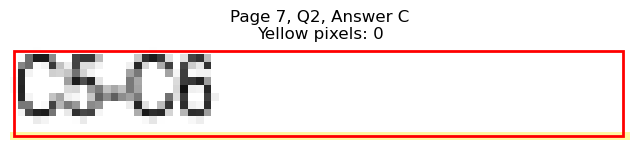

Page 7, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=356.0, y1=228.4
Page 7, Q2, D: Yellow pixels: 784
Page 7, Q2, D: Total non-white pixels: 960
Page 7, Q2, D: Yellow percentage: 81.7%


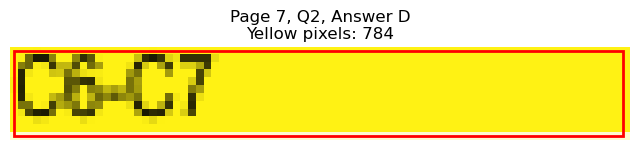


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=204.2, y1=291.6
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 692
Page 7, Q3, A: Yellow percentage: 0.0%


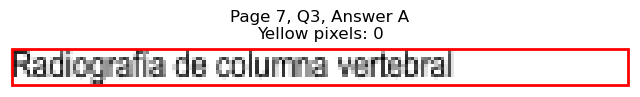

Page 7, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=159.1, y1=304.2
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 442
Page 7, Q3, B: Yellow percentage: 0.0%


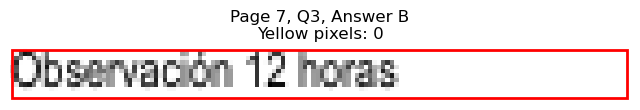

Page 7, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=497.5, y1=291.6
Page 7, Q3, C: Yellow pixels: 213
Page 7, Q3, C: Total non-white pixels: 1093
Page 7, Q3, C: Yellow percentage: 19.5%


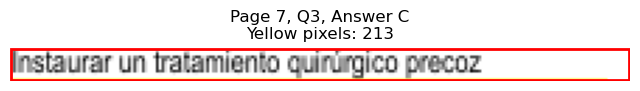

Page 7, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=401.3, y1=304.2
Page 7, Q3, D: Yellow pixels: 1090
Page 7, Q3, D: Total non-white pixels: 1377
Page 7, Q3, D: Yellow percentage: 79.2%


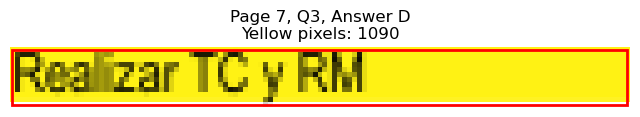


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=261.4, y1=342.0
Page 7, Q4, A: Yellow pixels: 1861
Page 7, Q4, A: Total non-white pixels: 2568
Page 7, Q4, A: Yellow percentage: 72.5%


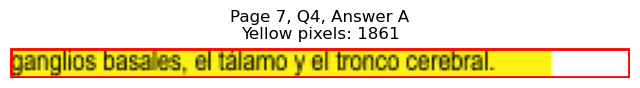

Page 7, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=212.8, y1=354.7
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 721
Page 7, Q4, B: Yellow percentage: 0.0%


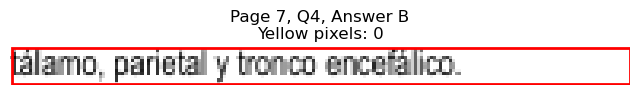

Page 7, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=539.6, y1=342.0
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 1079
Page 7, Q4, C: Yellow percentage: 0.0%


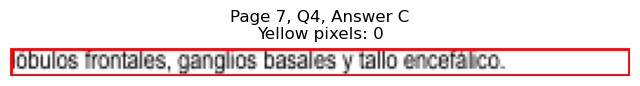

Page 7, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=509.6, y1=354.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 935
Page 7, Q4, D: Yellow percentage: 0.0%


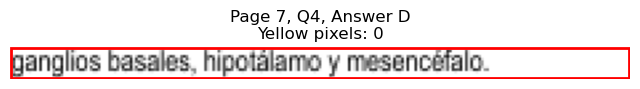


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=199.1, y1=405.1
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 670
Page 7, Q5, A: Yellow percentage: 0.0%


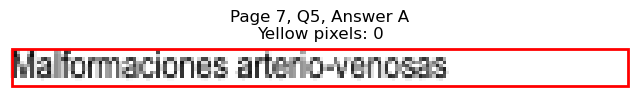

Page 7, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=163.1, y1=417.7
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 481
Page 7, Q5, B: Yellow percentage: 0.0%


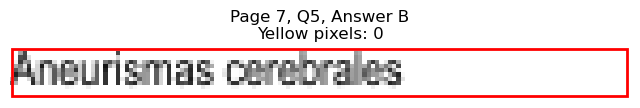

Page 7, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=412.7, y1=405.1
Page 7, Q5, C: Yellow pixels: 1144
Page 7, Q5, C: Total non-white pixels: 1498
Page 7, Q5, C: Yellow percentage: 76.4%


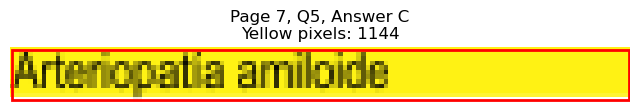

Page 7, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=442.3, y1=417.7
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 607
Page 7, Q5, D: Yellow percentage: 0.0%


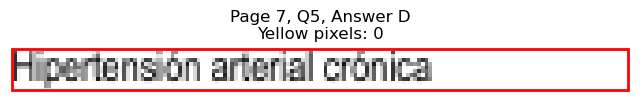


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=265.8, y1=493.5
Page 7, Q6, A: Yellow pixels: 1563
Page 7, Q6, A: Total non-white pixels: 2572
Page 7, Q6, A: Yellow percentage: 60.8%


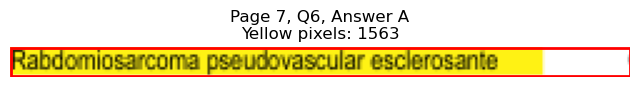

Page 7, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=156.0, y1=506.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 488
Page 7, Q6, B: Yellow percentage: 0.0%


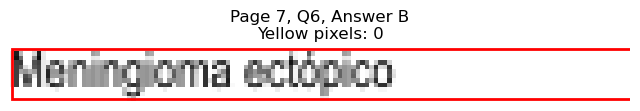

Page 7, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=427.3, y1=493.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 490
Page 7, Q6, C: Yellow percentage: 0.0%


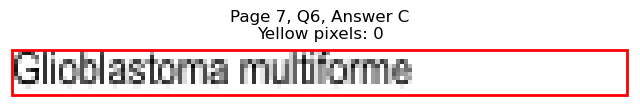

Page 7, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=476.9, y1=506.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 757
Page 7, Q6, D: Yellow percentage: 0.0%


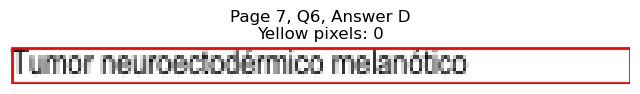


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=452.9, y1=569.2
Page 7, Q7, A: Yellow pixels: 435
Page 7, Q7, A: Total non-white pixels: 2400
Page 7, Q7, A: Yellow percentage: 18.1%


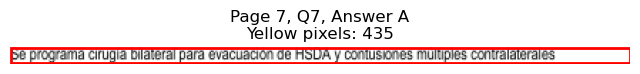

Page 7, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=436.9, y1=581.8
Page 7, Q7, B: Yellow pixels: 3627
Page 7, Q7, B: Total non-white pixels: 5028
Page 7, Q7, B: Yellow percentage: 72.1%


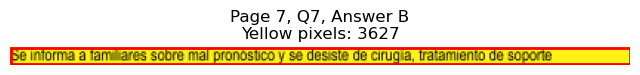

Page 7, Q7 - C: Detected box: x0=68.8, y0=583.4, x1=271.3, y1=594.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 1034
Page 7, Q7, C: Yellow percentage: 0.0%


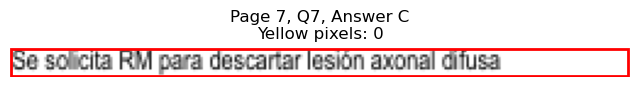

Page 7, Q7 - D: Detected box: x0=68.8, y0=596.0, x1=443.8, y1=607.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 1853
Page 7, Q7, D: Yellow percentage: 0.0%


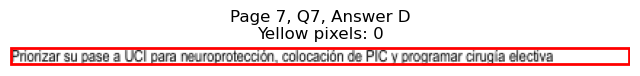


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=121.0, y1=645.0
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 267
Page 7, Q8, A: Yellow percentage: 0.0%


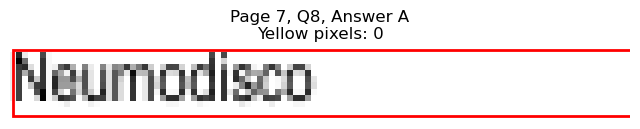

Page 7, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=149.0, y1=657.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 409
Page 7, Q8, B: Yellow percentage: 0.0%


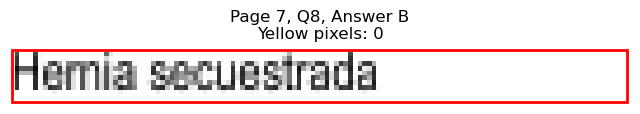

Page 7, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=401.2, y1=645.0
Page 7, Q8, C: Yellow pixels: 1193
Page 7, Q8, C: Total non-white pixels: 1500
Page 7, Q8, C: Yellow percentage: 79.5%


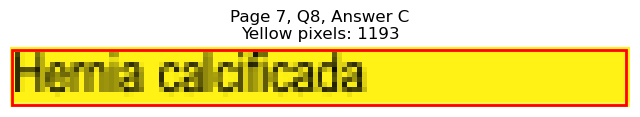

Page 7, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=409.7, y1=657.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 439
Page 7, Q8, D: Yellow percentage: 0.0%


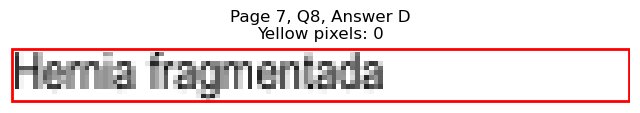


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=90.8, y1=720.7
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 72
Page 7, Q9, A: Yellow percentage: 0.0%


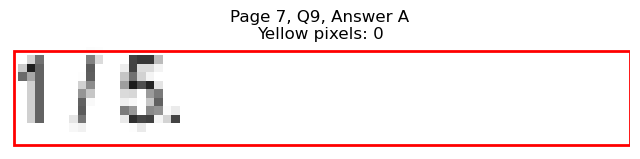

Page 7, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=90.8, y1=733.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 78
Page 7, Q9, B: Yellow percentage: 0.0%


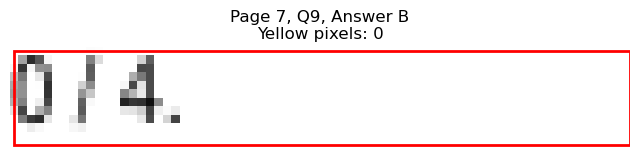

Page 7, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=355.1, y1=720.7
Page 7, Q9, C: Yellow pixels: 79
Page 7, Q9, C: Total non-white pixels: 180
Page 7, Q9, C: Yellow percentage: 43.9%


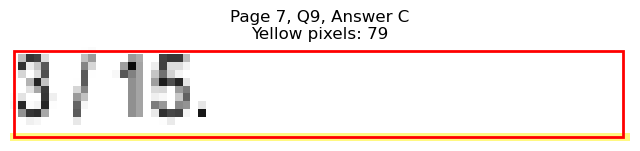

Page 7, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=350.0, y1=733.3
Page 7, Q9, D: Yellow pixels: 760
Page 7, Q9, D: Total non-white pixels: 888
Page 7, Q9, D: Yellow percentage: 85.6%


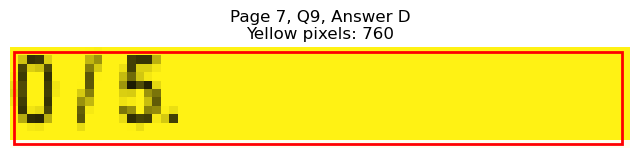


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=393.2, y1=114.8
Page 8, Q1, A: Yellow pixels: 3317
Page 8, Q1, A: Total non-white pixels: 4512
Page 8, Q1, A: Yellow percentage: 73.5%


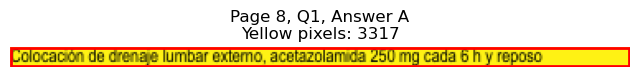

Page 8, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=371.3, y1=127.4
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 1546
Page 8, Q1, B: Yellow percentage: 0.0%


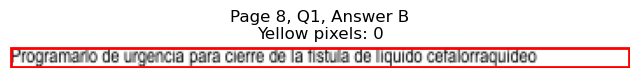

Page 8, Q1 - C: Detected box: x0=68.8, y0=129.0, x1=260.9, y1=140.0
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 936
Page 8, Q1, C: Yellow percentage: 0.0%


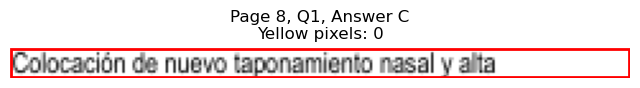

Page 8, Q1 - D: Detected box: x0=68.8, y0=141.7, x1=253.3, y1=152.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 926
Page 8, Q1, D: Yellow percentage: 0.0%


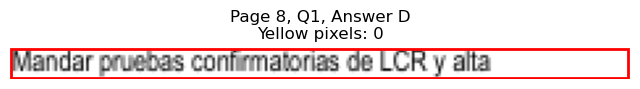


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=149.0, y1=190.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 407
Page 8, Q2, A: Yellow percentage: 0.0%


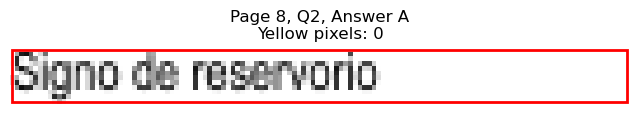

Page 8, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=159.1, y1=203.1
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 468
Page 8, Q2, B: Yellow percentage: 0.0%


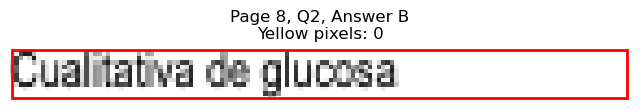

Page 8, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=391.2, y1=190.5
Page 8, Q2, C: Yellow pixels: 1010
Page 8, Q2, C: Total non-white pixels: 1380
Page 8, Q2, C: Yellow percentage: 73.2%


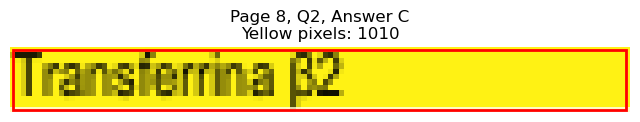

Page 8, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=387.1, y1=203.1
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 292
Page 8, Q2, D: Yellow percentage: 0.0%


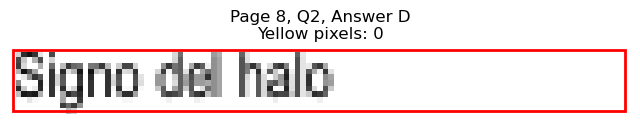


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=537.8, y1=266.2
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 2337
Page 8, Q3, A: Yellow percentage: 0.0%


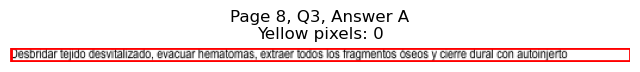

Page 8, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=501.1, y1=278.8
Page 8, Q3, B: Yellow pixels: 1
Page 8, Q3, B: Total non-white pixels: 2634
Page 8, Q3, B: Yellow percentage: 0.0%


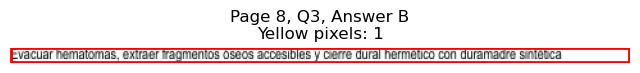

Page 8, Q3 - C: Detected box: x0=68.8, y0=280.5, x1=541.1, y1=291.6
Page 8, Q3, C: Yellow pixels: 3821
Page 8, Q3, C: Total non-white pixels: 5664
Page 8, Q3, C: Yellow percentage: 67.5%


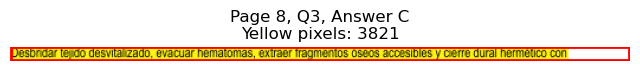

Page 8, Q3 - D: Detected box: x0=68.8, y0=305.7, x1=389.8, y1=316.8
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 1644
Page 8, Q3, D: Yellow percentage: 0.0%


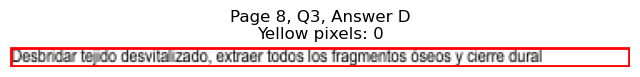


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=192.7, y1=379.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 622
Page 8, Q4, A: Yellow percentage: 0.0%


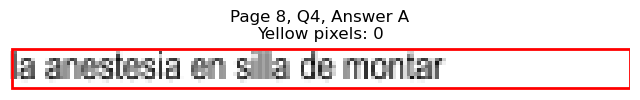

Page 8, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=221.8, y1=392.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 815
Page 8, Q4, B: Yellow percentage: 0.0%


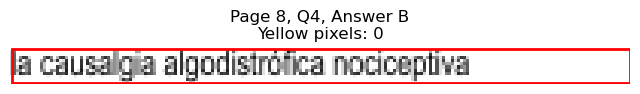

Page 8, Q4 - C: Detected box: x0=327.5, y0=368.8, x1=485.5, y1=379.9
Page 8, Q4, C: Yellow pixels: 1907
Page 8, Q4, C: Total non-white pixels: 2508
Page 8, Q4, C: Yellow percentage: 76.0%


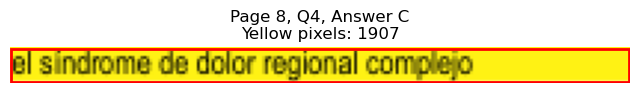

Page 8, Q4 - D: Detected box: x0=327.5, y0=381.4, x1=455.9, y1=392.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 678
Page 8, Q4, D: Yellow percentage: 0.0%


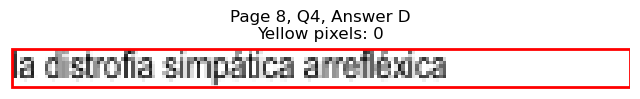


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=444.6, x1=154.1, y1=455.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 433
Page 8, Q5, A: Yellow percentage: 0.0%


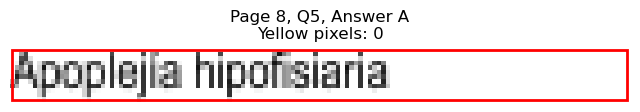

Page 8, Q5 - B: Detected box: x0=68.3, y0=457.2, x1=186.6, y1=468.2
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 592
Page 8, Q5, B: Yellow percentage: 0.0%


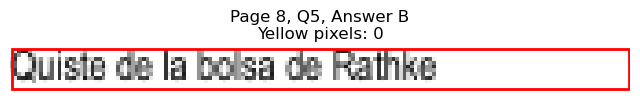

Page 8, Q5 - C: Detected box: x0=327.5, y0=444.6, x1=470.4, y1=455.6
Page 8, Q5, C: Yellow pixels: 1557
Page 8, Q5, C: Total non-white pixels: 2328
Page 8, Q5, C: Yellow percentage: 66.9%


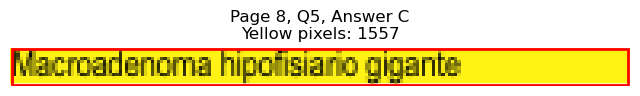

Page 8, Q5 - D: Detected box: x0=327.5, y0=457.2, x1=433.8, y1=468.2
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 586
Page 8, Q5, D: Yellow percentage: 0.0%


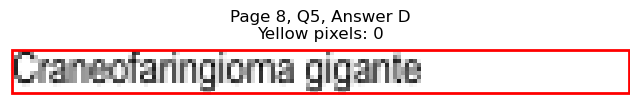


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=495.1, x1=137.0, y1=506.1
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 390
Page 8, Q6, A: Yellow percentage: 0.0%


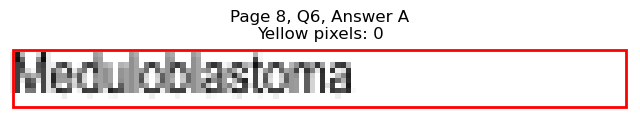

Page 8, Q6 - B: Detected box: x0=68.3, y0=507.7, x1=119.9, y1=518.7
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 292
Page 8, Q6, B: Yellow percentage: 0.0%


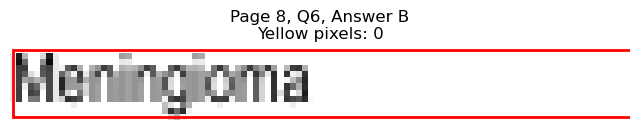

Page 8, Q6 - C: Detected box: x0=327.5, y0=495.1, x1=382.7, y1=506.1
Page 8, Q6, C: Yellow pixels: 960
Page 8, Q6, C: Total non-white pixels: 1166
Page 8, Q6, C: Yellow percentage: 82.3%


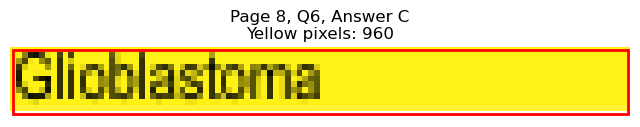

Page 8, Q6 - D: Detected box: x0=327.5, y0=507.7, x1=362.0, y1=518.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 145
Page 8, Q6, D: Yellow percentage: 0.0%


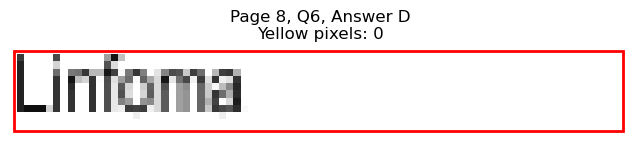


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=100.4, y1=556.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 169
Page 8, Q7, A: Yellow percentage: 0.0%


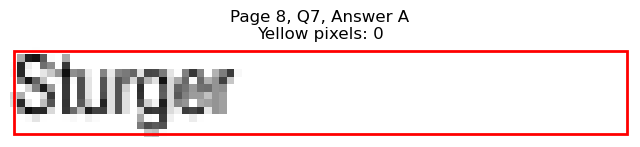

Page 8, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=100.4, y1=569.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 165
Page 8, Q7, B: Yellow percentage: 0.0%


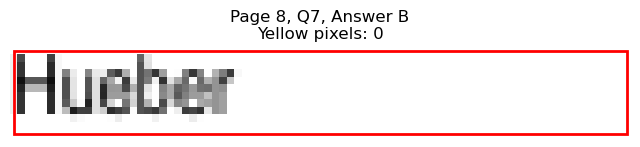

Page 8, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=364.1, y1=556.5
Page 8, Q7, C: Yellow pixels: 828
Page 8, Q7, C: Total non-white pixels: 1056
Page 8, Q7, C: Yellow percentage: 78.4%


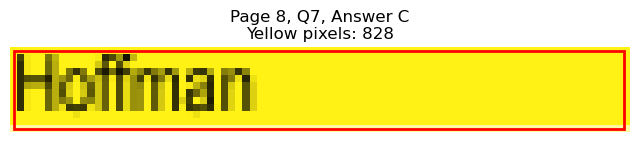

Page 8, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=357.1, y1=569.2
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 143
Page 8, Q7, D: Yellow percentage: 0.0%


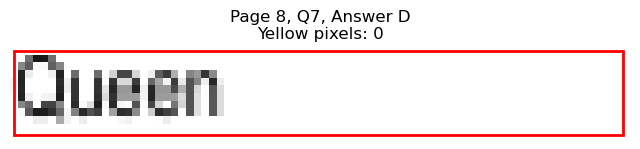


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=257.9, y1=619.6
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 937
Page 8, Q8, A: Yellow percentage: 0.0%


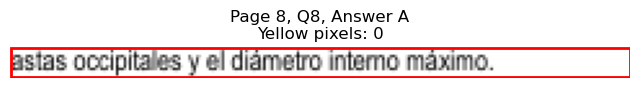

Page 8, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=269.4, y1=632.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 1043
Page 8, Q8, B: Yellow percentage: 0.0%


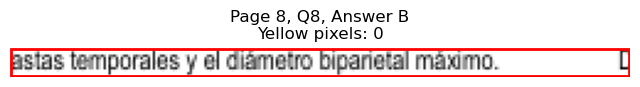

Page 8, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=518.6, y1=619.6
Page 8, Q8, C: Yellow pixels: 1800
Page 8, Q8, C: Total non-white pixels: 2556
Page 8, Q8, C: Yellow percentage: 70.4%


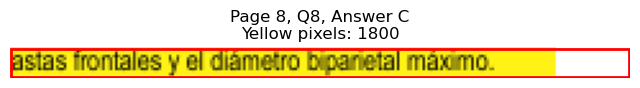

Page 8, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=509.5, y1=632.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 899
Page 8, Q8, D: Yellow percentage: 0.0%


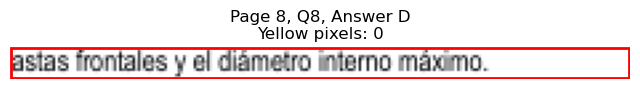


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=152.0, y1=695.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 387
Page 8, Q9, A: Yellow percentage: 0.0%


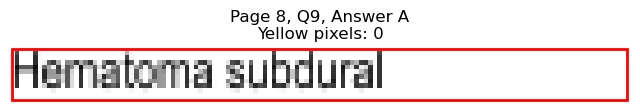

Page 8, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=140.5, y1=708.1
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 376
Page 8, Q9, B: Yellow percentage: 0.0%


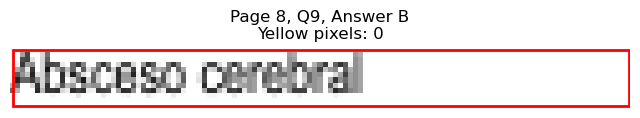

Page 8, Q9 - C: Detected box: x0=327.5, y0=684.3, x1=401.2, y1=695.4
Page 8, Q9, C: Yellow pixels: 125
Page 8, Q9, C: Total non-white pixels: 513
Page 8, Q9, C: Yellow percentage: 24.4%


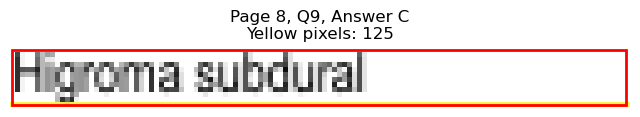

Page 8, Q9 - D: Detected box: x0=327.5, y0=697.0, x1=405.2, y1=708.1
Page 8, Q9, D: Yellow pixels: 1123
Page 8, Q9, D: Total non-white pixels: 1421
Page 8, Q9, D: Yellow percentage: 79.0%


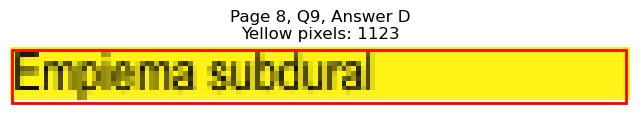


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=151.6, y1=127.4
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 465
Page 9, Q1, A: Yellow percentage: 0.0%


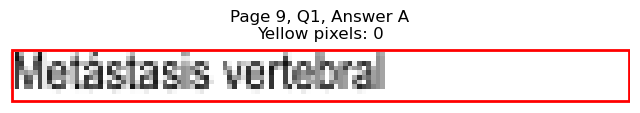

Page 9, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=146.5, y1=140.0
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 393
Page 9, Q1, B: Yellow percentage: 0.0%


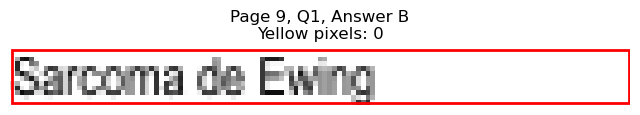

Page 9, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=421.2, y1=127.4
Page 9, Q1, C: Yellow pixels: 1244
Page 9, Q1, C: Total non-white pixels: 1740
Page 9, Q1, C: Yellow percentage: 71.5%


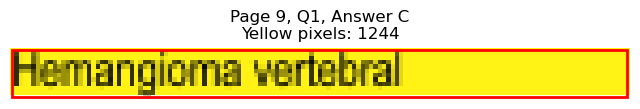

Page 9, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=417.7, y1=140.0
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 461
Page 9, Q1, D: Yellow percentage: 0.0%


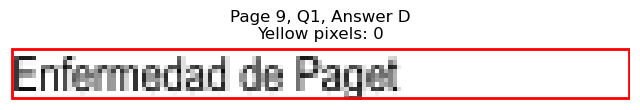


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=108.4, y1=177.9
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 196
Page 9, Q2, A: Yellow percentage: 0.0%


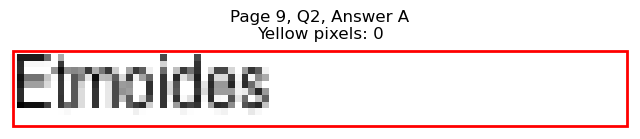

Page 9, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=115.4, y1=190.5
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 244
Page 9, Q2, B: Yellow percentage: 0.0%


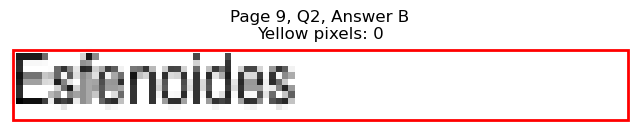

Page 9, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=356.5, y1=177.9
Page 9, Q2, C: Yellow pixels: 854
Page 9, Q2, C: Total non-white pixels: 960
Page 9, Q2, C: Yellow percentage: 89.0%


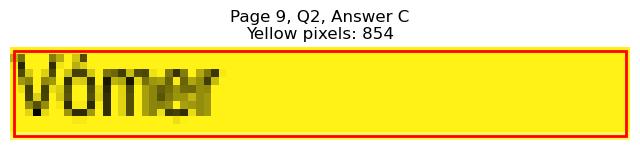

Page 9, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=358.1, y1=190.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 155
Page 9, Q2, D: Yellow percentage: 0.0%


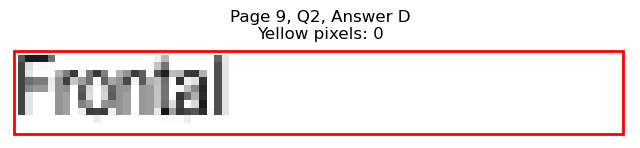


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=197.8, y1=228.4
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 656
Page 9, Q3, A: Yellow percentage: 0.0%


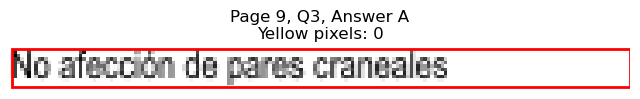

Page 9, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=127.9, y1=241.0
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 303
Page 9, Q3, B: Yellow percentage: 0.0%


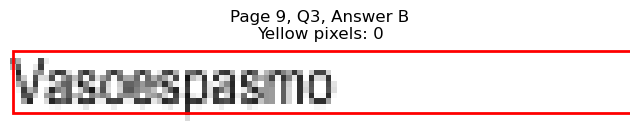

Page 9, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=442.8, y1=228.4
Page 9, Q3, C: Yellow pixels: 1384
Page 9, Q3, C: Total non-white pixels: 1992
Page 9, Q3, C: Yellow percentage: 69.5%


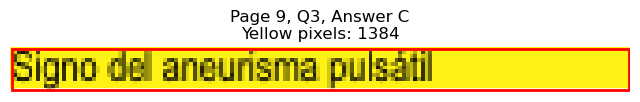

Page 9, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=463.8, y1=241.0
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 658
Page 9, Q3, D: Yellow percentage: 0.0%


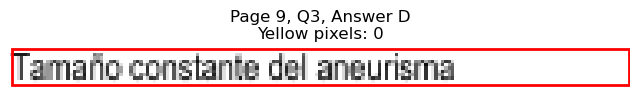


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=249.4, y1=278.8
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 948
Page 9, Q4, A: Yellow percentage: 0.0%


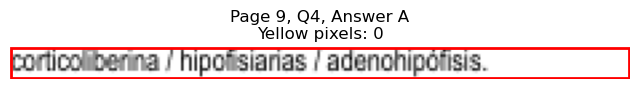

Page 9, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=238.3, y1=291.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 877
Page 9, Q4, B: Yellow percentage: 0.0%


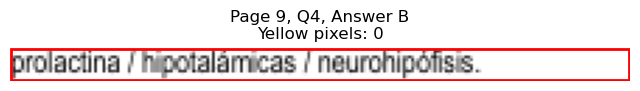

Page 9, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=514.0, y1=278.8
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 1169
Page 9, Q4, C: Yellow percentage: 0.0%


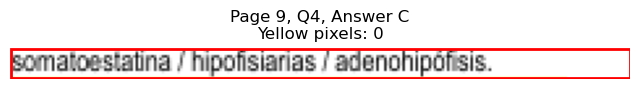

Page 9, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=541.1, y1=291.6
Page 9, Q4, D: Yellow pixels: 1561
Page 9, Q4, D: Total non-white pixels: 2556
Page 9, Q4, D: Yellow percentage: 61.1%


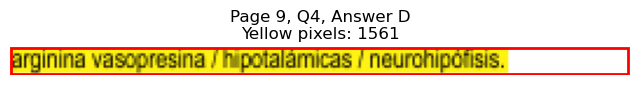


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=318.3, x1=178.1, y1=329.4
Page 9, Q5, A: Yellow pixels: 161
Page 9, Q5, A: Total non-white pixels: 666
Page 9, Q5, A: Yellow percentage: 24.2%


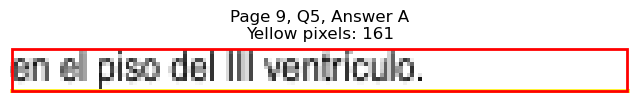

Page 9, Q5 - B: Detected box: x0=68.3, y0=330.9, x1=183.6, y1=342.0
Page 9, Q5, B: Yellow pixels: 1570
Page 9, Q5, B: Total non-white pixels: 1992
Page 9, Q5, B: Yellow percentage: 78.8%


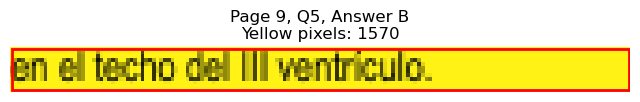

Page 9, Q5 - C: Detected box: x0=327.5, y0=318.3, x1=477.0, y1=329.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 719
Page 9, Q5, C: Yellow percentage: 0.0%


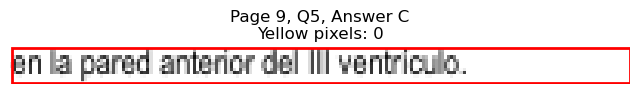

Page 9, Q5 - D: Detected box: x0=327.5, y0=330.9, x1=459.5, y1=342.0
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 633
Page 9, Q5, D: Yellow percentage: 0.0%


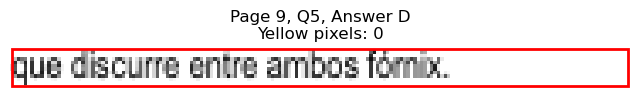


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=368.8, x1=386.8, y1=379.9
Page 9, Q6, A: Yellow pixels: 3160
Page 9, Q6, A: Total non-white pixels: 4428
Page 9, Q6, A: Yellow percentage: 71.4%


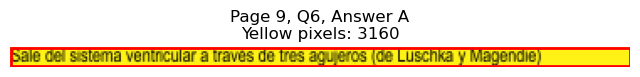

Page 9, Q6 - B: Detected box: x0=68.3, y0=381.4, x1=405.7, y1=392.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 1651
Page 9, Q6, B: Yellow percentage: 0.0%


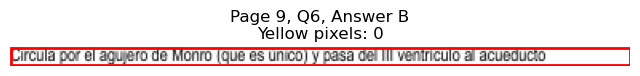

Page 9, Q6 - C: Detected box: x0=68.8, y0=394.0, x1=398.4, y1=405.1
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 1653
Page 9, Q6, C: Yellow percentage: 0.0%


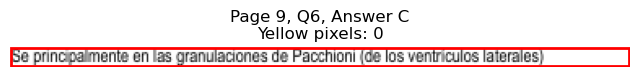

Page 9, Q6 - D: Detected box: x0=68.8, y0=406.6, x1=401.3, y1=417.7
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 1678
Page 9, Q6, D: Yellow percentage: 0.0%


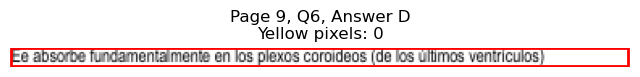


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=172.6, y1=480.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 560
Page 9, Q7, A: Yellow percentage: 0.0%


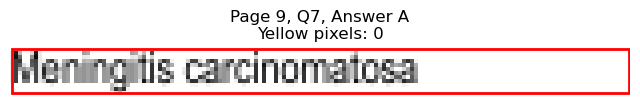

Page 9, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=185.2, y1=493.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 547
Page 9, Q7, B: Yellow percentage: 0.0%


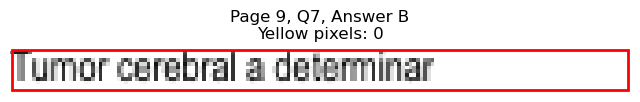

Page 9, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=525.0, y1=480.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 1193
Page 9, Q7, C: Yellow percentage: 0.0%


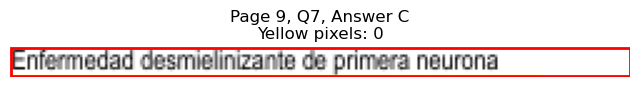

Page 9, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=470.9, y1=493.5
Page 9, Q7, D: Yellow pixels: 1557
Page 9, Q7, D: Total non-white pixels: 2328
Page 9, Q7, D: Yellow percentage: 66.9%


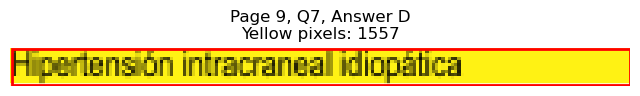


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=140.5, y1=556.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 331
Page 9, Q8, A: Yellow percentage: 0.0%


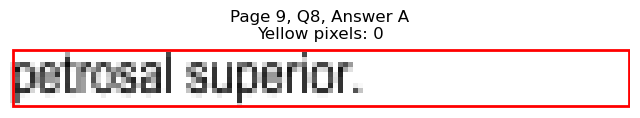

Page 9, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=112.0, y1=569.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 188
Page 9, Q8, B: Yellow percentage: 0.0%


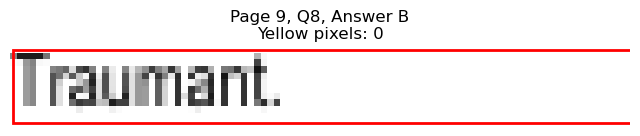

Page 9, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=376.7, y1=556.5
Page 9, Q8, C: Yellow pixels: 100
Page 9, Q8, C: Total non-white pixels: 315
Page 9, Q8, C: Yellow percentage: 31.7%


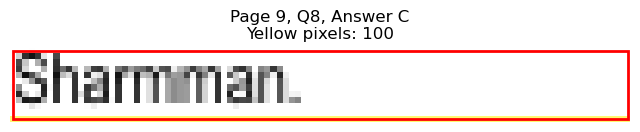

Page 9, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=370.1, y1=569.2
Page 9, Q8, D: Yellow pixels: 854
Page 9, Q8, D: Total non-white pixels: 1037
Page 9, Q8, D: Yellow percentage: 82.4%


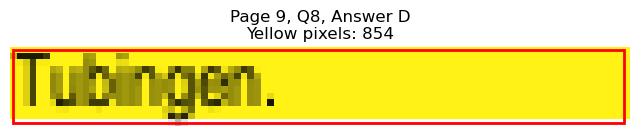


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=131.5, y1=619.6
Page 9, Q9, A: Yellow pixels: 1123
Page 9, Q9, A: Total non-white pixels: 1368
Page 9, Q9, A: Yellow percentage: 82.1%


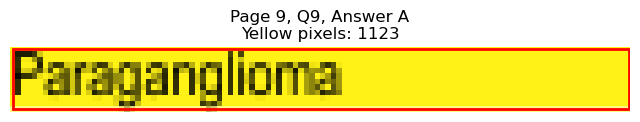

Page 9, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=132.5, y1=632.4
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 299
Page 9, Q9, B: Yellow percentage: 0.0%


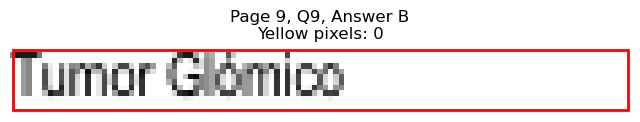

Page 9, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=396.7, y1=619.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 342
Page 9, Q9, C: Yellow percentage: 0.0%


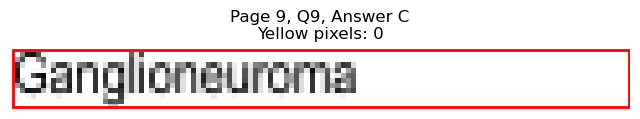

Page 9, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=391.2, y1=632.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 345
Page 9, Q9, D: Yellow percentage: 0.0%


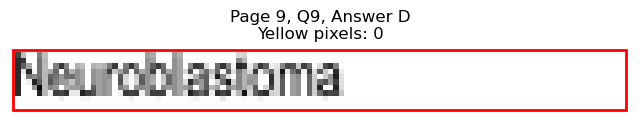


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=147.0, y1=682.8
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 401
Page 9, Q10, A: Yellow percentage: 0.0%


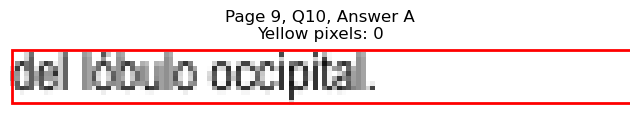

Page 9, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=150.0, y1=695.4
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 387
Page 9, Q10, B: Yellow percentage: 0.0%


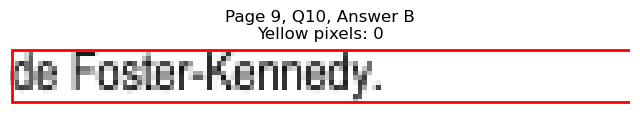

Page 9, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=381.1, y1=682.8
Page 9, Q10, C: Yellow pixels: 105
Page 9, Q10, C: Total non-white pixels: 364
Page 9, Q10, C: Yellow percentage: 28.8%


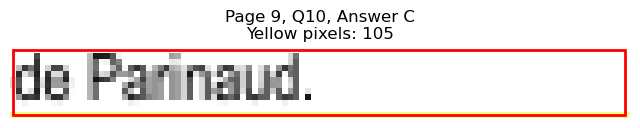

Page 9, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=389.6, y1=695.4
Page 9, Q10, D: Yellow pixels: 1024
Page 9, Q10, D: Total non-white pixels: 1356
Page 9, Q10, D: Yellow percentage: 75.5%


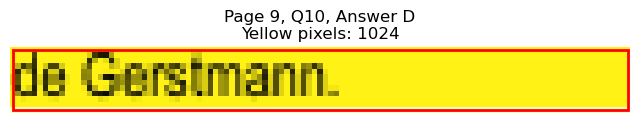


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=148.6, y1=745.9
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 378
Page 9, Q11, A: Yellow percentage: 0.0%


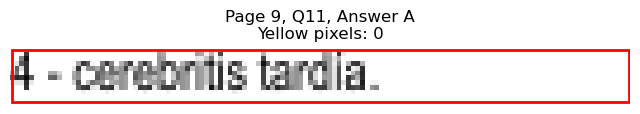

Page 9, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=143.0, y1=758.5
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 328
Page 9, Q11, B: Yellow percentage: 0.0%


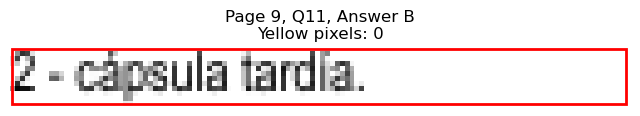

Page 9, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=401.8, y1=745.9
Page 9, Q11, C: Yellow pixels: 1272
Page 9, Q11, C: Total non-white pixels: 1500
Page 9, Q11, C: Yellow percentage: 84.8%


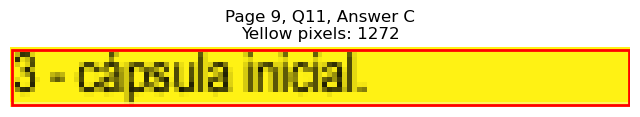

Page 9, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=404.8, y1=758.5
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 379
Page 9, Q11, D: Yellow percentage: 0.0%


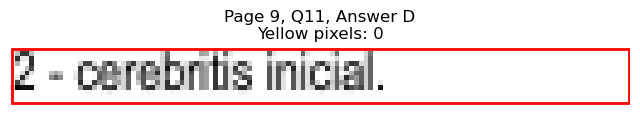


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=288.4, y1=102.2
Page 10, Q1, A: Yellow pixels: 271
Page 10, Q1, A: Total non-white pixels: 1640
Page 10, Q1, A: Yellow percentage: 16.5%


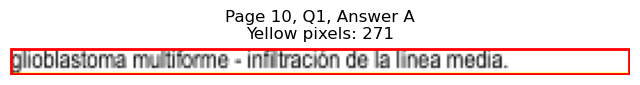

Page 10, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=302.5, y1=114.8
Page 10, Q1, B: Yellow pixels: 2565
Page 10, Q1, B: Total non-white pixels: 3420
Page 10, Q1, B: Yellow percentage: 75.0%


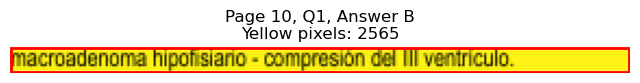

Page 10, Q1 - C: Detected box: x0=68.8, y0=116.4, x1=275.9, y1=127.4
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 1014
Page 10, Q1, C: Yellow percentage: 0.0%


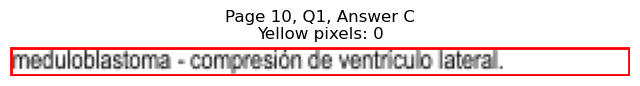

Page 10, Q1 - D: Detected box: x0=68.8, y0=129.0, x1=262.8, y1=140.0
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 919
Page 10, Q1, D: Yellow percentage: 0.0%


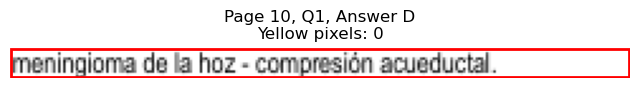


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=329.0, y1=190.5
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 1296
Page 10, Q2, A: Yellow percentage: 0.0%


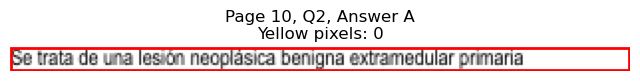

Page 10, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=422.4, y1=203.1
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 1748
Page 10, Q2, B: Yellow percentage: 0.0%


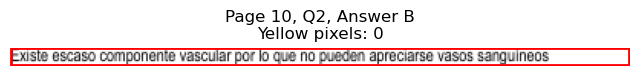

Page 10, Q2 - C: Detected box: x0=68.8, y0=204.7, x1=380.6, y1=215.7
Page 10, Q2, C: Yellow pixels: 4
Page 10, Q2, C: Total non-white pixels: 1913
Page 10, Q2, C: Yellow percentage: 0.2%


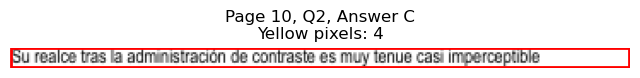

Page 10, Q2 - D: Detected box: x0=68.8, y0=217.4, x1=334.7, y1=228.4
Page 10, Q2, D: Yellow pixels: 2440
Page 10, Q2, D: Total non-white pixels: 3804
Page 10, Q2, D: Yellow percentage: 64.1%


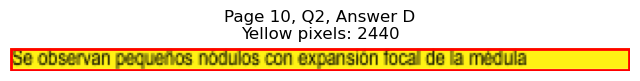


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=80.9, y1=291.6
Page 10, Q3, A: Yellow pixels: 653
Page 10, Q3, A: Total non-white pixels: 756
Page 10, Q3, A: Yellow percentage: 86.4%


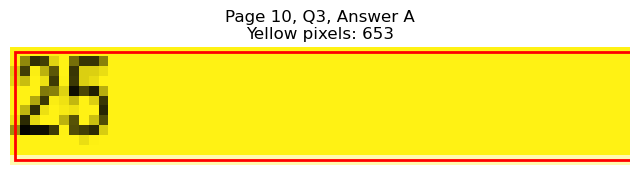

Page 10, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=80.9, y1=304.2
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 59
Page 10, Q3, B: Yellow percentage: 0.0%


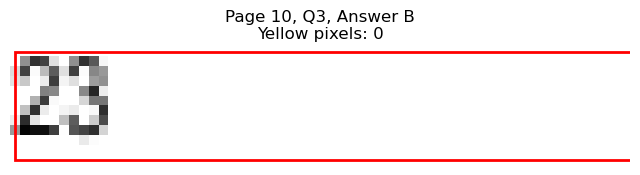

Page 10, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=340.1, y1=291.6
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 48
Page 10, Q3, C: Yellow percentage: 0.0%


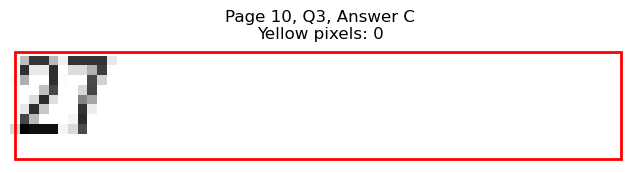

Page 10, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=340.1, y1=304.2
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 61
Page 10, Q3, D: Yellow percentage: 0.0%


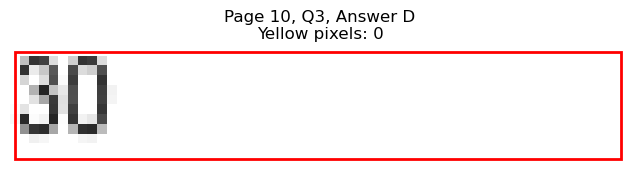


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=327.0, y1=354.7
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 1295
Page 10, Q4, A: Yellow percentage: 0.0%


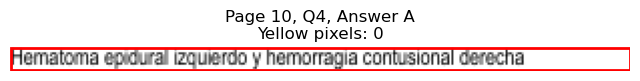

Page 10, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=313.4, y1=367.3
Page 10, Q4, B: Yellow pixels: 296
Page 10, Q4, B: Total non-white pixels: 1541
Page 10, Q4, B: Yellow percentage: 19.2%


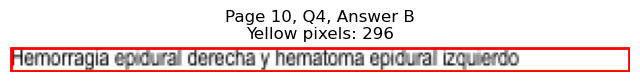

Page 10, Q4 - C: Detected box: x0=68.8, y0=368.8, x1=327.6, y1=379.9
Page 10, Q4, C: Yellow pixels: 2689
Page 10, Q4, C: Total non-white pixels: 3720
Page 10, Q4, C: Yellow percentage: 72.3%


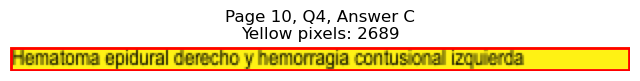

Page 10, Q4 - D: Detected box: x0=68.8, y0=381.4, x1=328.9, y1=392.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 1330
Page 10, Q4, D: Yellow percentage: 0.0%


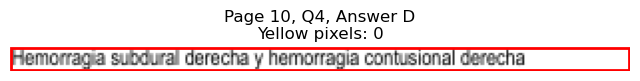


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=265.9, y1=430.4
Page 10, Q5, A: Yellow pixels: 20
Page 10, Q5, A: Total non-white pixels: 1025
Page 10, Q5, A: Yellow percentage: 2.0%


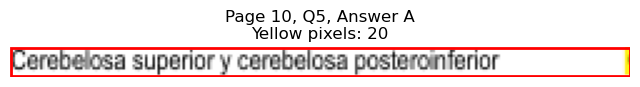

Page 10, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=253.3, y1=443.0
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 948
Page 10, Q5, B: Yellow percentage: 0.0%


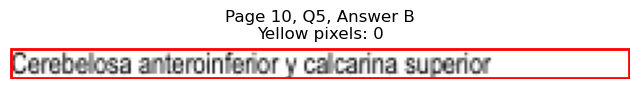

Page 10, Q5 - C: Detected box: x0=327.5, y0=419.4, x1=520.6, y1=430.4
Page 10, Q5, C: Yellow pixels: 1557
Page 10, Q5, C: Total non-white pixels: 2556
Page 10, Q5, C: Yellow percentage: 60.9%


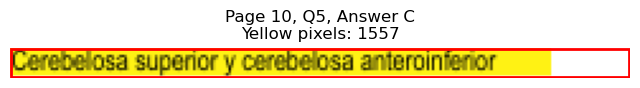

Page 10, Q5 - D: Detected box: x0=327.5, y0=432.0, x1=478.9, y1=443.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 749
Page 10, Q5, D: Yellow percentage: 0.0%


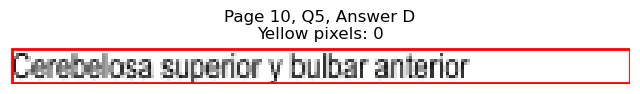


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=507.7, x1=371.8, y1=518.7
Page 10, Q6, A: Yellow pixels: 354
Page 10, Q6, A: Total non-white pixels: 1886
Page 10, Q6, A: Yellow percentage: 18.8%


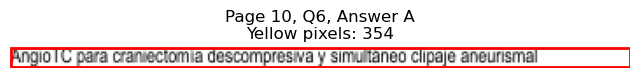

Page 10, Q6 - B: Detected box: x0=68.3, y0=520.3, x1=383.3, y1=531.3
Page 10, Q6, B: Yellow pixels: 2816
Page 10, Q6, B: Total non-white pixels: 4392
Page 10, Q6, B: Yellow percentage: 64.1%


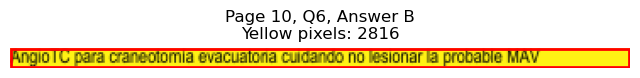

Page 10, Q6 - C: Detected box: x0=68.8, y0=532.9, x1=388.8, y1=543.9
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 1554
Page 10, Q6, C: Yellow percentage: 0.0%


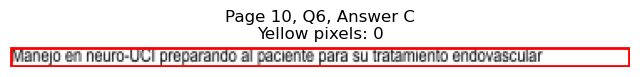

Page 10, Q6 - D: Detected box: x0=68.8, y0=545.5, x1=406.4, y1=556.5
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 1762
Page 10, Q6, D: Yellow percentage: 0.0%


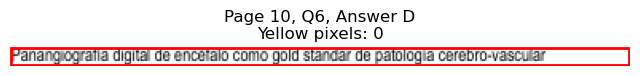


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=608.6, x1=210.1, y1=619.6
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 760
Page 10, Q7, A: Yellow percentage: 0.0%


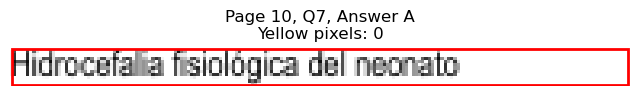

Page 10, Q7 - B: Detected box: x0=68.3, y0=621.3, x1=199.2, y1=632.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 658
Page 10, Q7, B: Yellow percentage: 0.0%


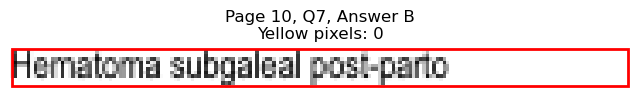

Page 10, Q7 - C: Detected box: x0=327.5, y0=608.6, x1=490.1, y1=619.6
Page 10, Q7, C: Yellow pixels: 1898
Page 10, Q7, C: Total non-white pixels: 2556
Page 10, Q7, C: Yellow percentage: 74.3%


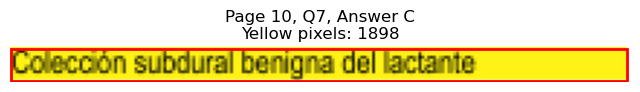

Page 10, Q7 - D: Detected box: x0=327.5, y0=621.3, x1=405.2, y1=632.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 409
Page 10, Q7, D: Yellow percentage: 0.0%


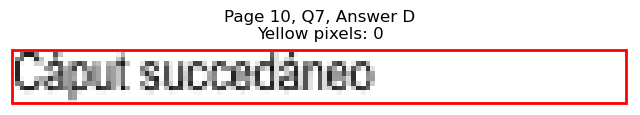


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=298.6, y1=670.2
Page 10, Q8, A: Yellow pixels: 281
Page 10, Q8, A: Total non-white pixels: 1684
Page 10, Q8, A: Yellow percentage: 16.7%


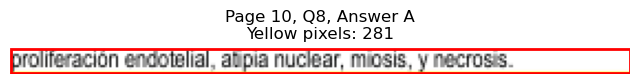

Page 10, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=298.4, y1=682.8
Page 10, Q8, B: Yellow pixels: 2505
Page 10, Q8, B: Total non-white pixels: 3372
Page 10, Q8, B: Yellow percentage: 74.3%


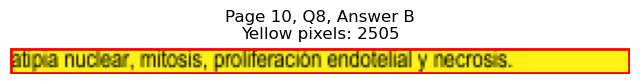

Page 10, Q8 - C: Detected box: x0=68.8, y0=684.3, x1=297.8, y1=695.4
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 1176
Page 10, Q8, C: Yellow percentage: 0.0%


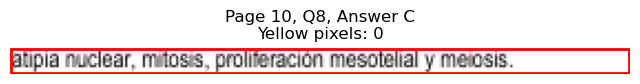

Page 10, Q8 - D: Detected box: x0=68.8, y0=697.0, x1=265.8, y1=708.1
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 1015
Page 10, Q8, D: Yellow percentage: 0.0%


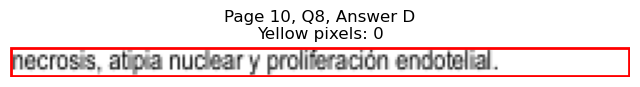


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 7 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=433.0, y1=102.2
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 1834
Page 11, Q1, A: Yellow percentage: 0.0%


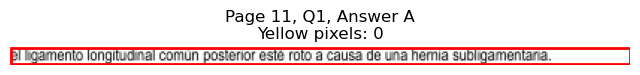

Page 11, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=369.4, y1=114.8
Page 11, Q1, B: Yellow pixels: 352
Page 11, Q1, B: Total non-white pixels: 1858
Page 11, Q1, B: Yellow percentage: 18.9%


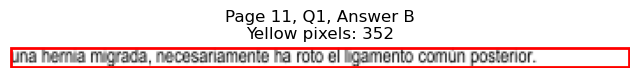

Page 11, Q1 - C: Detected box: x0=68.8, y0=116.4, x1=381.2, y1=127.4
Page 11, Q1, C: Yellow pixels: 2874
Page 11, Q1, C: Total non-white pixels: 4368
Page 11, Q1, C: Yellow percentage: 65.8%


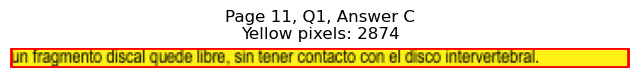

Page 11, Q1 - D: Detected box: x0=68.8, y0=129.0, x1=385.2, y1=140.0
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 1547
Page 11, Q1, D: Yellow percentage: 0.0%


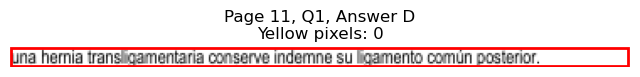


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=245.3, y1=203.1
Page 11, Q2, A: Yellow pixels: 213
Page 11, Q2, A: Total non-white pixels: 1312
Page 11, Q2, A: Yellow percentage: 16.2%


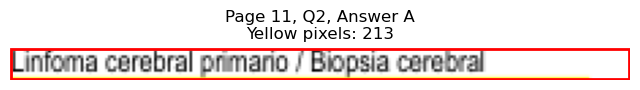

Page 11, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=236.8, y1=215.7
Page 11, Q2, B: Yellow pixels: 1912
Page 11, Q2, B: Total non-white pixels: 2568
Page 11, Q2, B: Yellow percentage: 74.5%


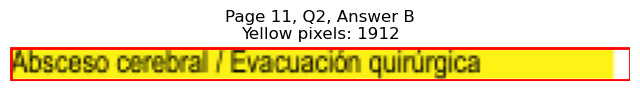

Page 11, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=457.9, y1=203.1
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 648
Page 11, Q2, C: Yellow percentage: 0.0%


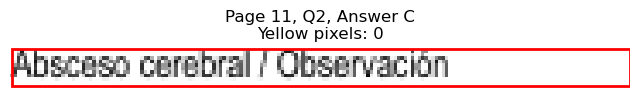

Page 11, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=453.8, y1=215.7
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 647
Page 11, Q2, D: Yellow percentage: 0.0%


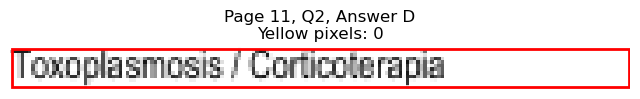


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=194.2, y1=266.2
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 631
Page 11, Q3, A: Yellow percentage: 0.0%


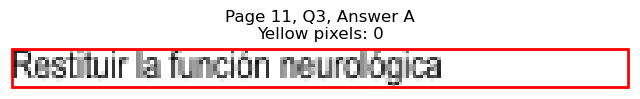

Page 11, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=250.8, y1=278.8
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 876
Page 11, Q3, B: Yellow percentage: 0.0%


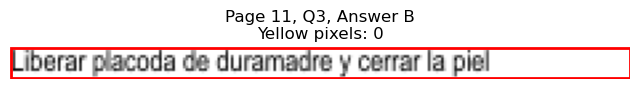

Page 11, Q3 - C: Detected box: x0=68.8, y0=280.5, x1=329.5, y1=291.6
Page 11, Q3, C: Yellow pixels: 312
Page 11, Q3, C: Total non-white pixels: 1575
Page 11, Q3, C: Yellow percentage: 19.8%


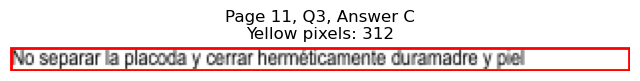

Page 11, Q3 - D: Detected box: x0=68.8, y0=293.1, x1=343.4, y1=304.2
Page 11, Q3, D: Yellow pixels: 2545
Page 11, Q3, D: Total non-white pixels: 3591
Page 11, Q3, D: Yellow percentage: 70.9%


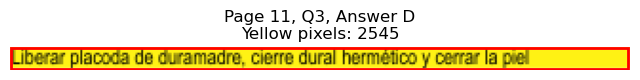


Page 11, Q3 - Selected Answer: D (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=257.4, y1=342.0
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 1208
Page 11, Q4, A: Yellow percentage: 0.0%


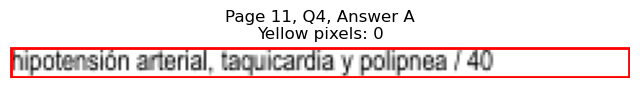

Page 11, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=319.0, y1=354.7
Page 11, Q4, B: Yellow pixels: 2671
Page 11, Q4, B: Total non-white pixels: 3612
Page 11, Q4, B: Yellow percentage: 73.9%


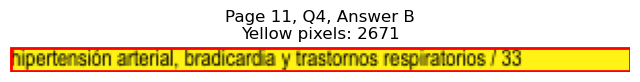

Page 11, Q4 - C: Detected box: x0=68.8, y0=356.2, x1=319.4, y1=367.3
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 1278
Page 11, Q4, C: Yellow percentage: 0.0%


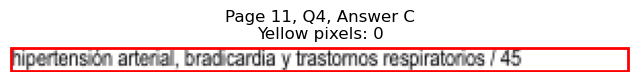

Page 11, Q4 - D: Detected box: x0=68.8, y0=368.8, x1=263.9, y1=379.9
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 1016
Page 11, Q4, D: Yellow percentage: 0.0%


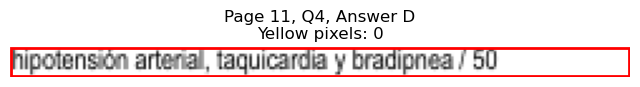


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=233.8, y1=443.0
Page 11, Q5, A: Yellow pixels: 1914
Page 11, Q5, A: Total non-white pixels: 2592
Page 11, Q5, A: Yellow percentage: 73.8%


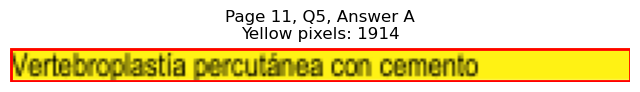

Page 11, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=162.6, y1=455.6
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 466
Page 11, Q5, B: Yellow percentage: 0.0%


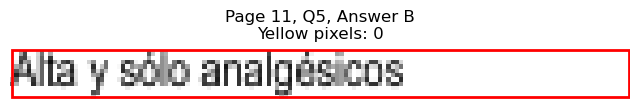

Page 11, Q5 - C: Detected box: x0=68.8, y0=457.2, x1=321.5, y1=468.2
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 1242
Page 11, Q5, C: Yellow percentage: 0.0%


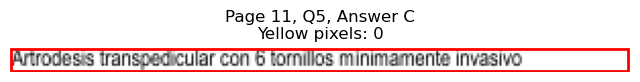

Page 11, Q5 - D: Detected box: x0=68.8, y0=469.8, x1=256.3, y1=480.8
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 924
Page 11, Q5, D: Yellow percentage: 0.0%


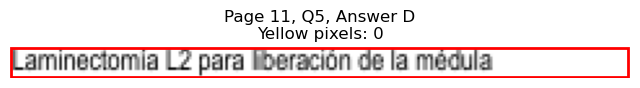


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=56.6, y0=520.3, x1=65.2, y1=531.3
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 60
Page 11, Q6, A: Yellow percentage: 0.0%


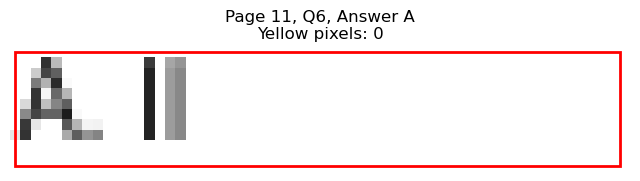

Page 11, Q6 - B: Detected box: x0=56.6, y0=532.9, x1=65.2, y1=543.9
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 50
Page 11, Q6, B: Yellow percentage: 0.0%


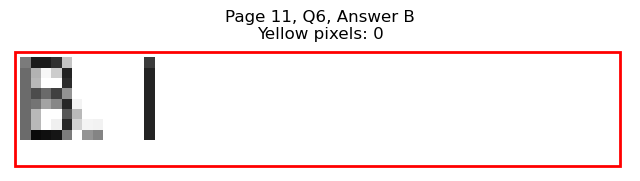

Page 11, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=337.6, y1=531.3
Page 11, Q6, C: Yellow pixels: 631
Page 11, Q6, C: Total non-white pixels: 732
Page 11, Q6, C: Yellow percentage: 86.2%


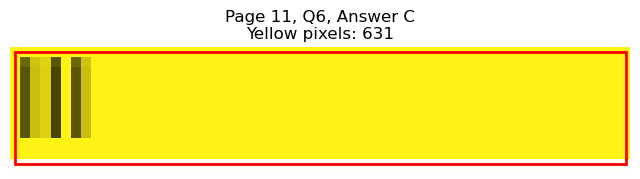

Page 11, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=338.5, y1=543.9
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 43
Page 11, Q6, D: Yellow percentage: 0.0%


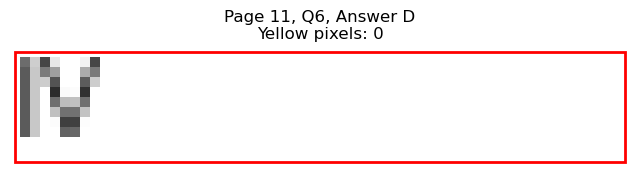


Page 11, Q6 - Selected Answer: C (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=236.3, y1=594.4
Page 11, Q7, A: Yellow pixels: 1745
Page 11, Q7, A: Total non-white pixels: 2628
Page 11, Q7, A: Yellow percentage: 66.4%


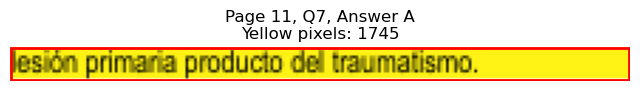

Page 11, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=233.8, y1=607.0
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 828
Page 11, Q7, B: Yellow percentage: 0.0%


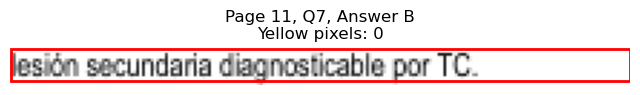

Page 11, Q7 - C: Detected box: x0=68.8, y0=608.6, x1=336.6, y1=619.6
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 1353
Page 11, Q7, C: Yellow percentage: 0.0%


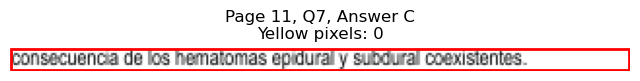

Page 11, Q7 - D: Detected box: x0=68.8, y0=621.3, x1=364.2, y1=632.4
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 1469
Page 11, Q7, D: Yellow percentage: 0.0%


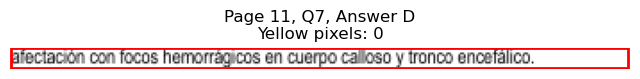


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuáles son las principales causas de vértebra...
1   Lactante femenina de 3 meses con macrocefalia,...
2   Mujer de 55 años referida de Ayacucho, con ate...
3   Varón de 33 años. TC: proceso expansivo el cua...
4   La hipótesis modificada de ...... establece qu...
..                                                ...
95  Neonato de 2 semanas con mielomeningocele. Exa...
96  La triada de Cushing se presenta en hipertensi...
97  Mujer de 85 años, después de caída sentada, ac...
98  Paciente acude a emergencia con cefalea muy in...
99  Un paciente es diagnosticado de daño axónico d...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                               Sarcomas osteogénicos   
1                           Síndrome de Chiari tipo 1   
2   Tumor del tercio medio del ala del esfenoides ...   
3   Anterior al infundíbulo y posterior a los cuer...   
4                                        Monro-Kellie   
..                                                ...   
95                   Restituir la función neurológica   
96  hipotensión arterial, taquicardia y polipnea / 40   
97             Vertebroplastía percutánea con cemento   
98                                                 II   
99          lesión primaria producto del traumatismo.   

                                             option_B  \
0                           Metástasis osteoclásticas   
1                        Malformación de Dandy Walker   
2   Tumor del III ventrículo más hipertensión endo...   
3   Posterior a la arteria basilar y anterior al i...   
4                                         Ramsay-Hunt   
..                                                ...   
95      Liberar placoda de duramadre y cerrar la piel   
96  hipertensión arterial, bradicardia y trastorno...   
97                            Alta y sólo analgésicos   
98                                                  I   
99           lesión secundaria diagnosticable por TC.   

                                             option_C  \
0                                 Esclerosis tuberosa   
1                              Malformación del molar   
2               Tumor de la región selar y supraselar   
3   Posterior a los cuerpos mamilares y anterior a...   
4                                         Hakim-Adams   
..                                                ...   
95  No separar la placoda y cerrar herméticamente ...   
96  hipertensión arterial, bradicardia y trastorno...   
97  Artrodesis transpedicular con 6 tornillos míni...   
98                                                III   
99  consecuencia de los hematomas epidural y subdu...   

                                             option_D  
0                                 Enfermedad de Paget  
1                           Síndrome de Chiari tipo 2  
2                           Quiste aracnoideo derecho  
3   Anterior a cuerpos mamilares, anterior al tope...  
4                                        Dandy-Walker  
..                                                ...  
95  Liberar placoda de duramadre, cierre dural her...  
96  hipotensión arterial, taquicardia y bradipnea ...  
97       Laminectomía L2 para liberación de la médula  
98                                                 IV  
99  afectación con focos hemorrágicos en cuerpo ca...  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuáles son las principales causas de vértebra...   
1   Lactante femenina de 3 meses con macrocefalia,...   
2   Mujer de 55 años referida de Ayacucho, con ate...   
3   Varón de 33 años. TC: proceso expansivo el cua...   
4   La hipótesis modificada de ...... establece qu...   
..                                                ...   
95  Neonato de 2 semanas con mielomeningocele. Exa...   
96  La triada de Cushing se presenta en hipertensi...   
97  Mujer de 85 años, después de caída sentada, ac...   
98  Paciente acude a emergencia con cefalea muy in...   
99  Un paciente es diagnosticado de daño axónico d...   

                                             option_A  \
0                               Sarcomas osteogénicos   
1                           Síndrome de Chiari tipo 1   
2   Tumor del tercio medio del ala del esfenoides ...   
3   Anterior al infundíbulo y posterior a los cuer...   
4                                        Monro-Kellie   
..                                                ...   
95                   Restituir la función neurológica   
96  hipotensión arterial, taquicardia y polipnea / 40   
97             Vertebroplastía percutánea con cemento   
98                                                 II   
99          lesión primaria producto del traumatismo.   

                                             option_B  \
0                           Metástasis osteoclásticas   
1                        Malformación de Dandy Walker   
2   Tumor del III ventrículo más hipertensión endo...   
3   Posterior a la arteria basilar y anterior al i...   
4                                         Ramsay-Hunt   
..                                                ...   
95      Liberar placoda de duramadre y cerrar la piel   
96  hipertensión arterial, bradicardia y trastorno...   
97                            Alta y sólo analgésicos   
98                                                  I   
99           lesión secundaria diagnosticable por TC.   

                                             option_C  \
0                                 Esclerosis tuberosa   
1                              Malformación del molar   
2               Tumor de la región selar y supraselar   
3   Posterior a los cuerpos mamilares y anterior a...   
4                                         Hakim-Adams   
..                                                ...   
95  No separar la placoda y cerrar herméticamente ...   
96  hipertensión arterial, bradicardia y trastorno...   
97  Artrodesis transpedicular con 6 tornillos míni...   
98                                                III   
99  consecuencia de los hematomas epidural y subdu...   

                                             option_D correct_answer  
0                                 Enfermedad de Paget              A  
1                           Síndrome de Chiari tipo 2              B  
2                           Quiste aracnoideo derecho              A  
3   Anterior a cuerpos mamilares, anterior al tope...              D  
4                                        Dandy-Walker              A  
..                                                ...            ...  
95  Liberar placoda de duramadre, cierre dural her...              D  
96  hipotensión arterial, taquicardia y bradipnea ...              B  
97       Laminectomía L2 para liberación de la médula              A  
98                                                 IV              C  
99  afectación con focos hemorrágicos en cuerpo ca...              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/NEUROCIRUGIA.csv
